In [1]:
import wave
import numpy as np
import librosa
import os 
import matplotlib.pyplot as plt


import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout

Using TensorFlow backend.


In [2]:
emotions = {
    
    ('01','N'):'Neutral',
    '02':'calm',
    ('03','F'):'Happy',
    ('04','T'):'Sad',
    ('05','W'):'Angry',
    ('06','A'):'Fearful',
    ('07','E'):'Disgust',
     '08':'surprised',
    'L':'Boredom' 
    }
    
   

In [3]:
def get_key_from_dict(d, k):
    for key, value in d.items():
        if k in key:
            return value
    return None

In [4]:
def verify_properties_of_audio(name_of_audio):
    wav_struct = wave.open(name_of_audio,'r')
    
    sampling_frequency = wav_struct.getframerate()
    
    bit_depth = wav_struct.getsampwidth()
    
    no_channels = wav_struct.getnchannels()
    
    wav_struct.close()
    
    return sampling_frequency,bit_depth,no_channels

In [5]:
def load_data(path):
    
    all_mfccs = []
    all_chroma = []
    all_mel = []
    all_labels = []
    
    if path == 'D:/Desktop/emodb':
    
        directory = 'D:\Desktop\emodb\wav'
        sub_directory = os.listdir(directory)
    
        for file_name in sub_directory:
            audio_name = os.path.join(directory,file_name)
            mfccs,chroma,mel = extract_features(audio_name)
            
            sintax_gender = file_name[:2]
            if sintax_gender in ('08','09','13','14','16'):
                gender = 'Female '
            else:
                gender = 'Male '
        
            # get the emotion
            audio = os.path.splitext(audio_name)[0]

            emotion = get_key_from_dict(emotions, audio[-2])
            label = gender+emotion
            all_labels.append(label)
            
            all_mfccs.append(mfccs)
            all_chroma.append(chroma)
            all_mel.append(mel)
                
            
    else:
            
        for subdir,dirs, files in os.walk(path):
        
            if subdir == 'D:/Desktop/Ravdess':
                pass
            else:
                if(int(subdir[-1]) % 2 == 1):
                    gender = 'Male '
                else:
                    gender = 'Female '
            for file in files:
                emotion = get_key_from_dict(emotions, file.split("-")[2])
                
                label = gender+emotion
                all_labels.append(label)
                    
                audio_file_name = os.path.join(subdir,file)
                mfccs,chroma,mel = extract_features(audio_file_name)
                all_mfccs.append(mfccs)
                all_chroma.append(chroma)
                all_mel.append(mel)
                
                
    all_mfccs = np.array(all_mfccs)
    all_chroma = np.array(all_chroma)
    all_mel = np.array(all_mel)
    all_labels = np.array(all_labels)
                
    
    return all_mfccs, all_chroma, all_mel, all_labels 

In [6]:
def all_features_combined(dimension_of_dataset,all_mfccs,all_chroma,all_mel):
    all_features = []
    for i in range(0,dimension_of_dataset):
        result=np.array([])
        result=np.hstack((result, all_mfccs[i]))
        result=np.hstack((result, all_chroma[i]))
        result=np.hstack((result, all_mel[i]))
        all_features.append(result)
        
    all_features = np.array(all_features)
    return all_features

In [7]:
def extract_features(name_of_audio):   
    # read the audio file
    wav_struct = wave.open(name_of_audio,'r')
    sampling_frequency = wav_struct.getframerate()
    wav_bytes = wav_struct.readframes(-1)
    wav_data = np.frombuffer(wav_bytes,dtype='int16')
    #normalize wav_data to [-1,1]
    wav_data = wav_data/float(max(abs(wav_data)))
    wav_struct.close()
    
    
    mfccs=np.mean(librosa.feature.mfcc(wav_data, sampling_frequency, n_mfcc=40).T,axis=0)

    chroma=np.mean(librosa.feature.chroma_stft(wav_data,sampling_frequency).T,axis=0)

    mel=np.mean(librosa.feature.melspectrogram(wav_data, sampling_frequency).T,axis=0)

    return mfccs,chroma,mel

In [8]:
def prepare_data(features):
    #Scale data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0,1))
    transformed_features = scaler.fit_transform(features)
    return transformed_features

In [9]:
def normalize_data(all_mfccs, all_chroma, all_mel, all_features):
    
    all_mfccs = prepare_data(all_mfccs)
    all_chroma =  prepare_data(all_chroma)
    all_mel =  prepare_data(all_mel)
    all_features = prepare_data(all_features)
    
    return all_mfccs, all_chroma, all_mel, all_features

In [10]:
def display_features(features,all_labels,name):
           
    for i in range(20):
       
        plt.title("{}{}{}{}{}".format(name,' from audio file ',
                              i+1,' : ',all_labels[i]))
        plt.xlabel("Coefficient Number")
        plt.ylabel('Value')
        plt.plot(features[i])
        plt.show()

In [11]:
def display_graphics(all_mfccs,all_chroma,all_mel,all_labels):
    name = ' MFCC coefficients'
    display_features(all_mfccs,all_labels,name)
    name = ' Chroma coefficients'
    display_features(all_chroma,all_labels,name)
    name = ' Mel coefficients'
    display_features(all_mel,all_labels,name)

In [12]:
def create_dataframe(features,name,all_labels):
    
    no_of_items = features.shape[0]
    no_of_features = features.shape[1]
    
    print("{}{}{}{}".format('Each audio file has: ', no_of_features,name,' features'))
    
    index_of_dataframe = ['Audio_file'+str(i+1) for i in range(no_of_items)]
    index_of_dataframe=np.array(index_of_dataframe)
    feature_number = ['Feature '+ str(i+1) + name for i in range(no_of_features)]

    df_features = pd.DataFrame(features,columns=feature_number)
    df_labels = pd.DataFrame(all_labels,columns = ['Emotion'])
    

    df = pd.concat([df_features,df_labels],axis=1)
        
    df.set_index(index_of_dataframe,inplace=True)
    
    
    return df

In [13]:
def display_coeffcients_in_dataframe(all_features,all_mfccs,all_chroma,all_mel,all_labels): 
    
    print("{}{}{}".format('The database contain: ', all_features.shape[0],' wav files'))
    
    df_mfccs = create_dataframe(all_mfccs,' MFCCs', all_labels)
    
    df_chromas = create_dataframe(all_chroma,' Chromas', all_labels)
    
    df_mels = create_dataframe(all_mel,' Mels', all_labels)
    
    return df_mfccs,df_chromas,df_mels

In [14]:
def create_csv_file(df_mfcc,df_chroma,df_mel):
    df_mfcc = df_mfcc[df_mfcc.columns[:-1]]
    df_chroma = df_chroma[df_chroma.columns[:-1]]
    df = pd.concat([df_mfcc,df_chroma,df_mel],axis=1, sort=False)
    return df

In [15]:
def implement_machine_learning(extracted_features,all_labels,speech_encoder):
    all_labels = speech_encoder.fit_transform(all_labels)
    X_train,X_test,y_train,y_test = train_test_split( extracted_features,all_labels,test_size=0.2,random_state=7)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,y_train)
    logreg = LogisticRegression(max_iter = 10000)
    logreg.fit(X_train,y_train)
    dtree = DecisionTreeClassifier()
    dtree.fit(X_train,y_train)
    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    sv = SVC(kernel='rbf')
    sv.fit(X_train,y_train)
 
    models = [knn,logreg,dtree,rf,sv]
    
    for model in models:
        how_good_the_ML_model_is(model,X_test,y_train,y_test,speech_encoder)
        
    return models

In [16]:
import warnings
warnings.filterwarnings('ignore')

def how_good_the_ML_model_is(model,X_test,y_train,y_test,speech_encoder):
    print(model,'\n')
    y_pred = model.predict(X_test)
    
    print('Accuracy:',accuracy_score(y_pred,y_test)*100)
    
    y_test = speech_encoder.inverse_transform(y_test)
    y_pred = speech_encoder.inverse_transform(y_pred)
    
    print(classification_report(y_test,y_pred)) 
    
    cm = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
    #plot the confusion matrix
    sns.heatmap(df_cm,annot=True)
    plt.xlabel('Predicted label')
    plt.ylabel('Real label')
    plt.show()

In [17]:
def create_deep_learning_model(indimension,outdimension):

    model = Sequential()
    # layer 1 
    model.add(Dense(180, input_dim=indimension, activation='relu'))  
    #layer 2
    model.add(Dense(512, activation='relu'))  
    model.add(Dropout(0.1)) 
    #layer3 
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.1)) 
    #layer 4
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.1))  
    # output layer  
    model.add(Dense(outdimension, activation='softmax'))  
    #model compilation  
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 
    
    return model

In [18]:
def split_data_fit_evaluate_the_dl_model(name,extracted_features,no_of_features,out_dim):
    train_data,test_data,train_labels,test_labels = train_test_split(extracted_features,transformed_labels,
                                                                     test_size=0.2,random_state=10)
    features_based_model = create_deep_learning_model(no_of_features,out_dim)
    model_history = features_based_model.fit(train_data,train_labels,validation_split=0.15,epochs=200,batch_size=10)
    _ ,acc = features_based_model.evaluate(test_data,test_labels)
    print('\nUsing {} we obtained an accuracy of:{}'.format(name,acc*100) )
    
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    predictions = features_based_model.predict(test_data, batch_size=32,verbose=1)
    predictions = predictions.argmax(axis=1)
    
    
    real_values = test_labels.argmax(axis=1)
    
    return features_based_model,predictions,real_values

# Emodb database

In [19]:
path = 'D:/Desktop/emodb'
all_mfccs_emo, all_chroma_emo, all_mel_emo, all_labels_emo = load_data(path)

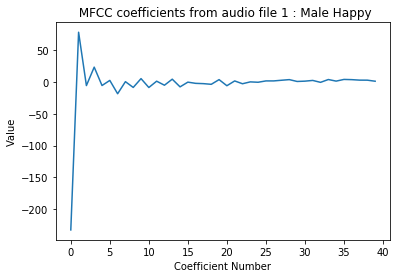

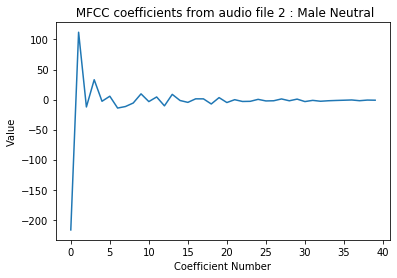

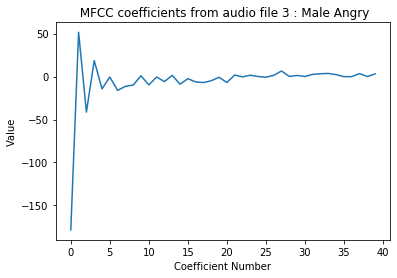

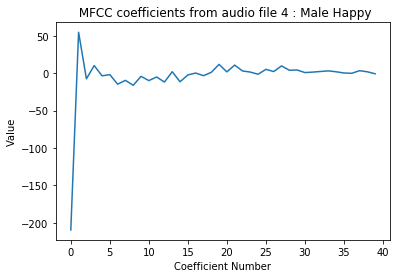

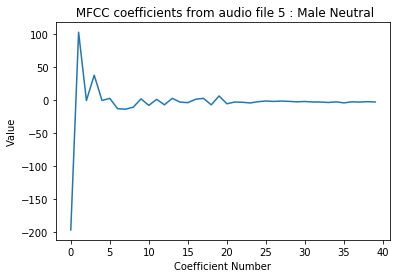

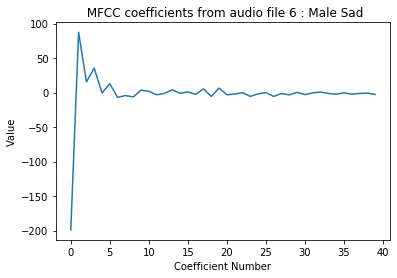

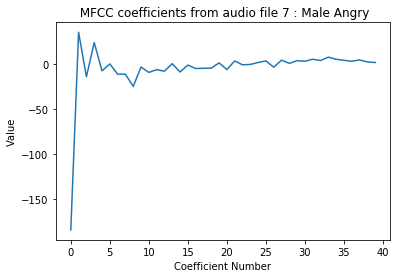

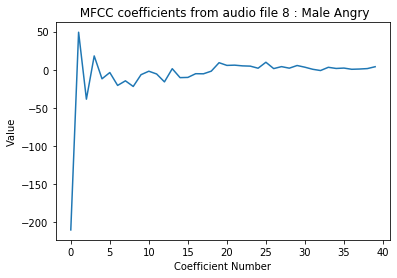

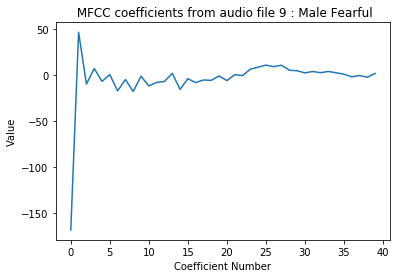

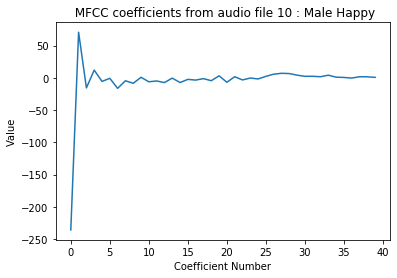

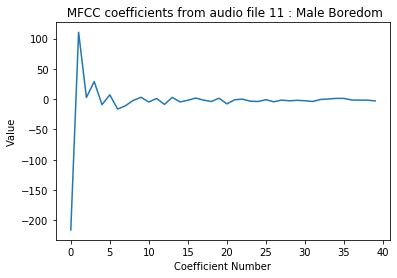

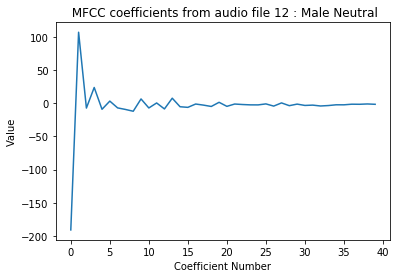

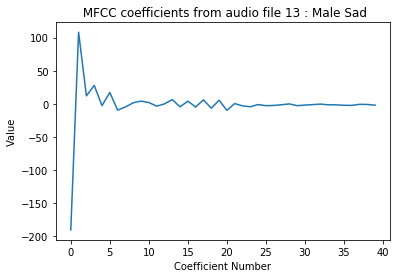

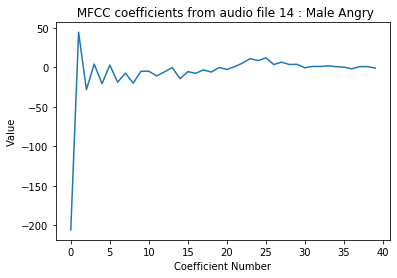

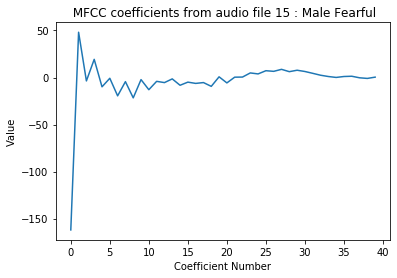

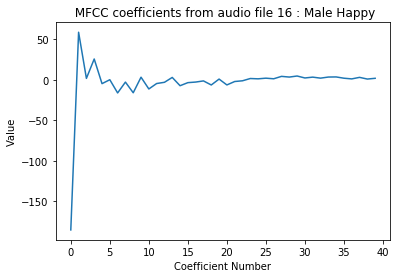

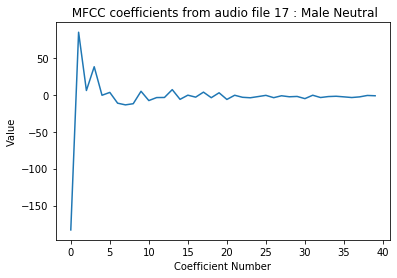

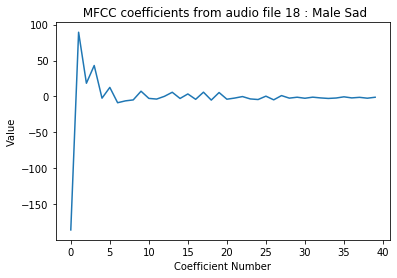

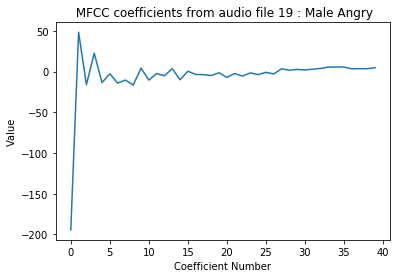

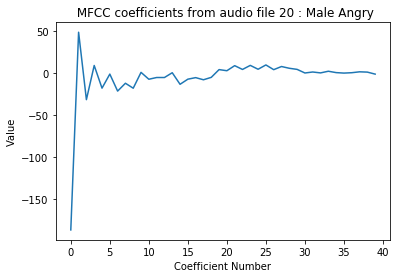

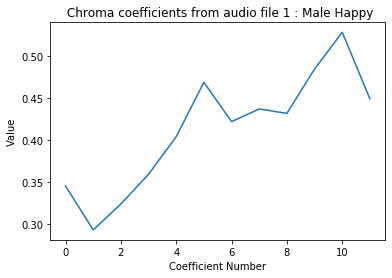

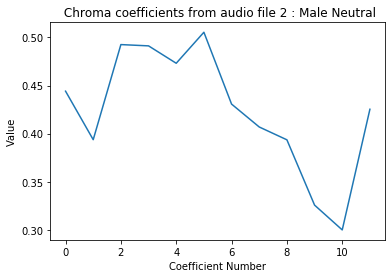

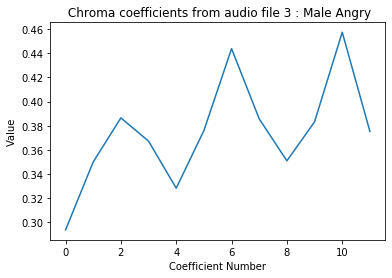

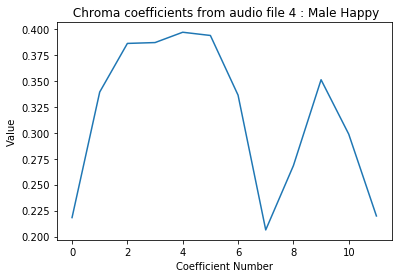

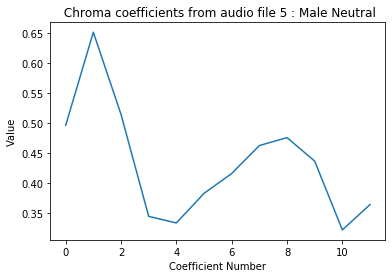

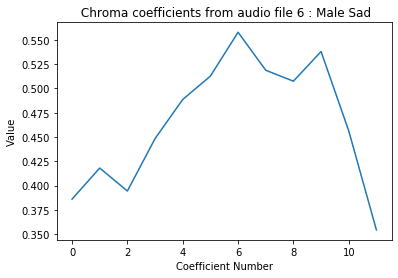

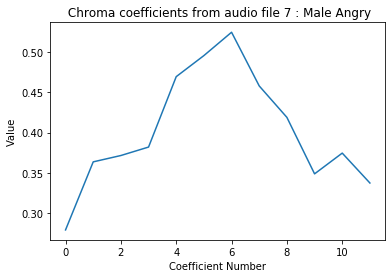

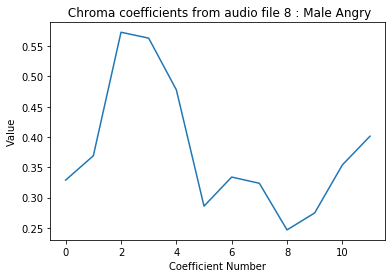

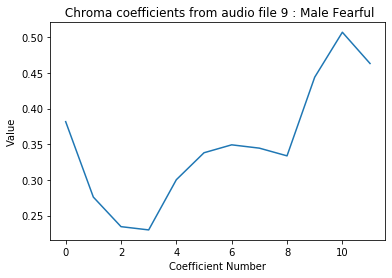

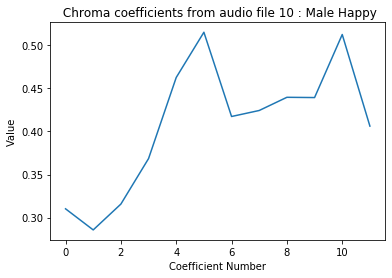

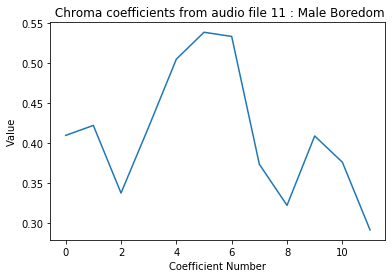

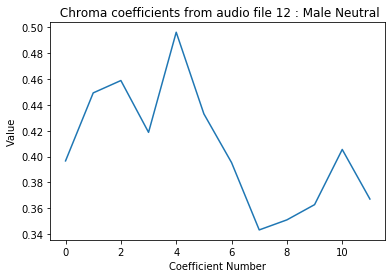

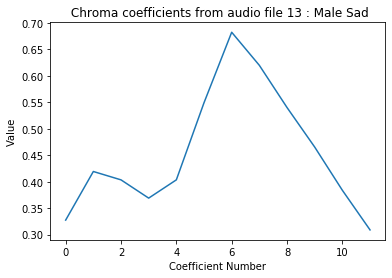

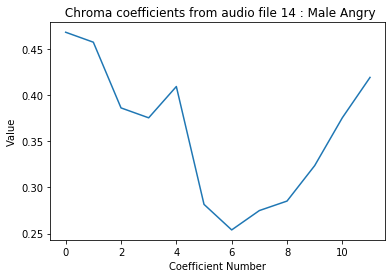

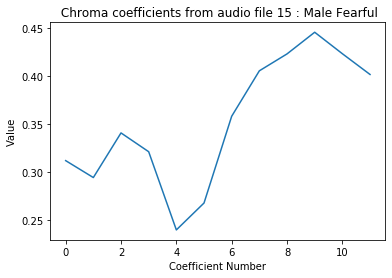

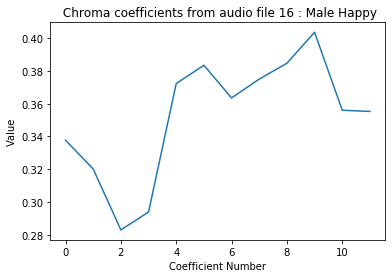

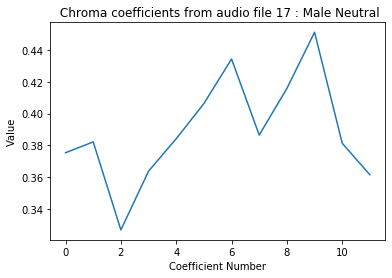

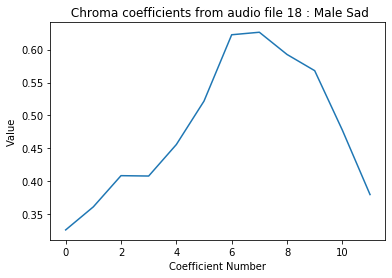

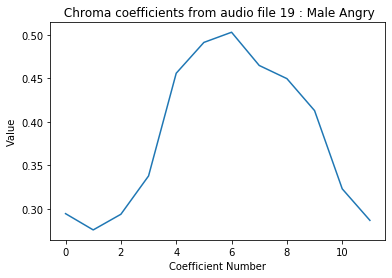

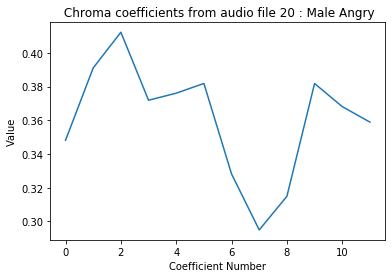

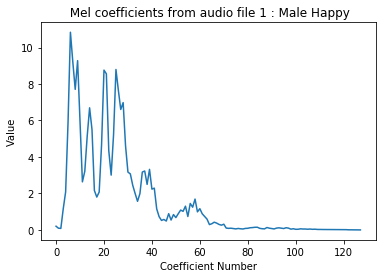

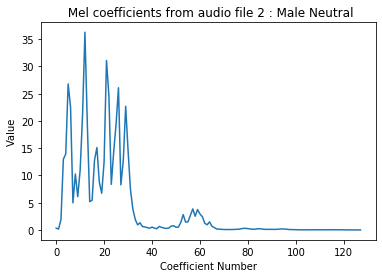

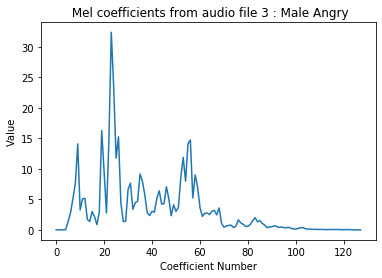

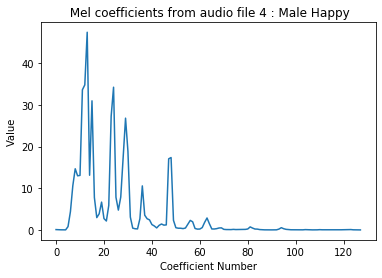

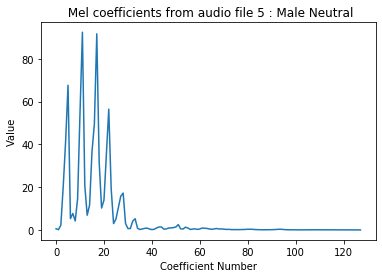

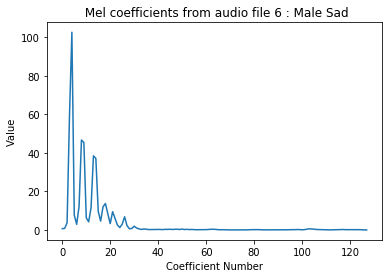

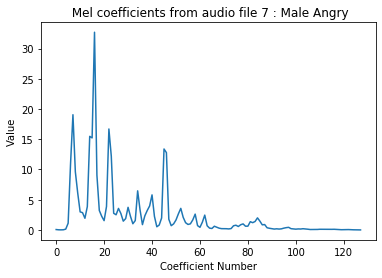

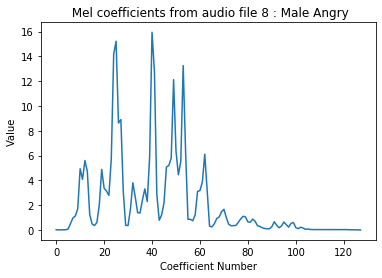

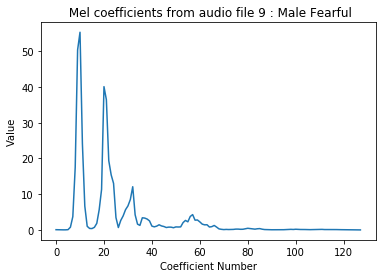

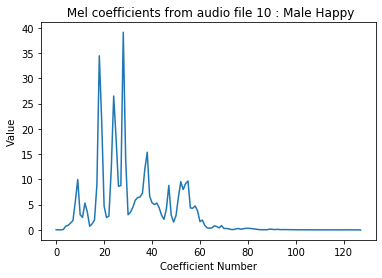

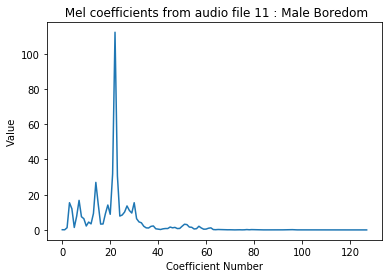

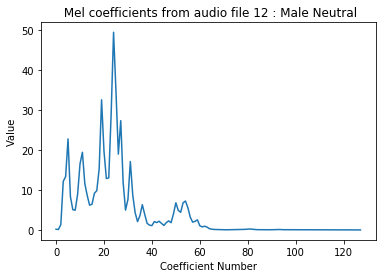

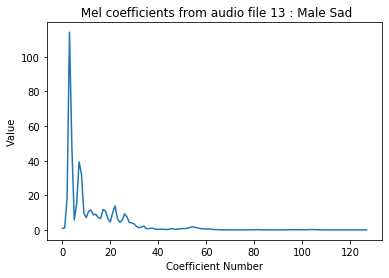

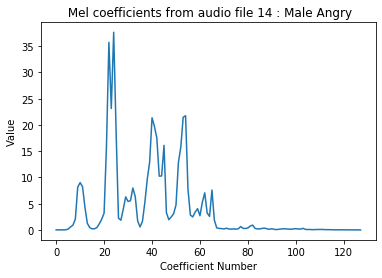

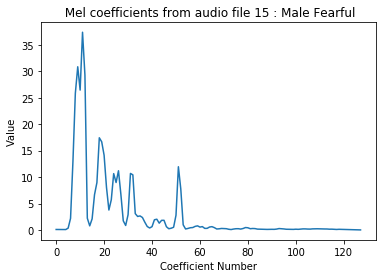

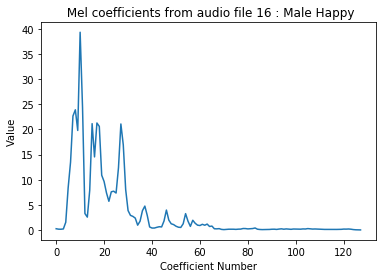

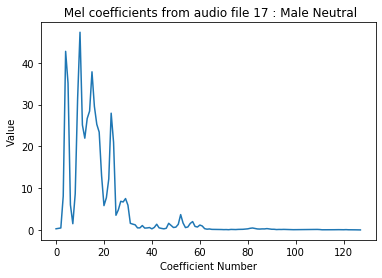

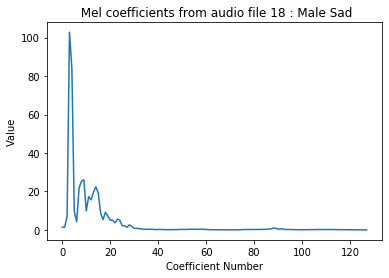

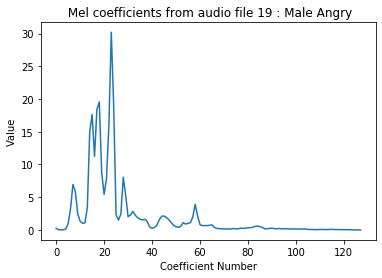

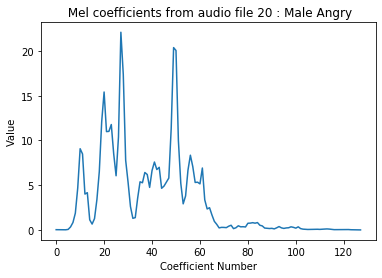

In [20]:
display_graphics(all_mfccs_emo, all_chroma_emo, all_mel_emo, all_labels_emo)

In [21]:
all_mfccs_emo.shape,all_chroma_emo.shape,all_mel_emo.shape

((535, 40), (535, 12), (535, 128))

In [22]:
all_features_emo = all_features_combined(all_mfccs_emo.shape[0],all_mfccs_emo, all_chroma_emo, all_mel_emo)

In [23]:
df_mfcc_emo,df_chroma_emo,df_mel_emo = display_coeffcients_in_dataframe(all_features_emo,all_mfccs_emo, all_chroma_emo, all_mel_emo,all_labels_emo)

The database contain: 535 wav files
Each audio file has: 40 MFCCs features
Each audio file has: 12 Chromas features
Each audio file has: 128 Mels features


In [24]:
df_mfcc_emo.head()

Feature 1 MFCCs  Feature 2 MFCCs  Feature 3 MFCCs  \
Audio_file1      -232.362305        78.019150        -5.732435   
Audio_file2      -216.899628       111.996506       -12.314363   
Audio_file3      -178.517181        51.614223       -41.377743   
Audio_file4      -209.477509        54.775944        -7.476145   
Audio_file5      -196.284119       103.256149        -0.246312   

             Feature 4 MFCCs  Feature 5 MFCCs  Feature 6 MFCCs  \
Audio_file1        23.232996        -5.623595         2.388345   
Audio_file2        32.993103        -2.850642         5.554549   
Audio_file3        18.636124       -14.272959        -0.527251   
Audio_file4        10.181810        -3.481082        -1.863994   
Audio_file5        38.239197        -0.095343         3.030204   

             Feature 7 MFCCs  Feature 8 MFCCs  Feature 9 MFCCs  \
Audio_file1       -18.549864         0.421055        -8.644818   
Audio_file2       -14.148485       -11.612885        -5.757543   
Audio_file3       -16.060371       -11.403684        -9.822012   
Audio_file4       -14.683190        -9.536597       -16.151005   
Audio_file5       -12.655691       -13.371084       -10.295249   

             Feature 10 MFCCs  ...  Feature 32 MFCCs  Feature 33 MFCCs  \
Audio_file1          5.200285  ...          2.354663         -0.641264   
Audio_file2          9.480168  ...         -1.351030         -2.823219   
Audio_file3          0.912337  ...          2.592654          3.298933   
Audio_file4         -4.199028  ...          1.491651          2.321586   
Audio_file5          2.276392  ...         -2.455327         -2.506595   

             Feature 34 MFCCs  Feature 35 MFCCs  Feature 36 MFCCs  \
Audio_file1          3.781198          1.281801          3.927532   
Audio_file2         -1.990323         -1.500707         -1.110486   
Audio_file3          3.653250          2.273728         -0.096653   
Audio_file4          3.119390          1.919350          0.312912   
Audio_file5         -3.178274         -2.186273         -3.779020   

             Feature 37 MFCCs  Feature 38 MFCCs  Feature 39 MFCCs  \
Audio_file1          3.590889          2.828990          2.766532   
Audio_file2         -0.682192         -1.912936         -0.860385   
Audio_file3         -0.060872          3.477501          0.006971   
Audio_file4         -0.100576          3.391063          1.913686   
Audio_file5         -2.204224         -2.534258         -1.933932   

             Feature 40 MFCCs       Emotion  
Audio_file1          1.110389    Male Happy  
Audio_file2         -1.076366  Male Neutral  
Audio_file3          3.153377    Male Angry  
Audio_file4         -0.755160    Male Happy  
Audio_file5         -2.452840  Male Neutral  

[5 rows x 41 columns]

In [25]:
df_chroma_emo.head()

Feature 1 Chromas  Feature 2 Chromas  Feature 3 Chromas  \
Audio_file1           0.345245           0.292777           0.323727   
Audio_file2           0.444154           0.393729           0.492586   
Audio_file3           0.293714           0.349974           0.386454   
Audio_file4           0.218291           0.339135           0.385907   
Audio_file5           0.495706           0.650708           0.514075   

             Feature 4 Chromas  Feature 5 Chromas  Feature 6 Chromas  \
Audio_file1           0.359279           0.404136           0.469069   
Audio_file2           0.491250           0.473173           0.505416   
Audio_file3           0.367205           0.328277           0.375919   
Audio_file4           0.386731           0.396666           0.393559   
Audio_file5           0.344281           0.333325           0.382546   

             Feature 7 Chromas  Feature 8 Chromas  Feature 9 Chromas  \
Audio_file1           0.422133           0.437216           0.431946   
Audio_file2           0.430738           0.406923           0.393588   
Audio_file3           0.443788           0.385607           0.350903   
Audio_file4           0.336132           0.206438           0.268269   
Audio_file5           0.415616           0.462125           0.475380   

             Feature 10 Chromas  Feature 11 Chromas  Feature 12 Chromas  \
Audio_file1            0.484931            0.528854            0.449319   
Audio_file2            0.325702            0.299914            0.425351   
Audio_file3            0.383182            0.457337            0.375277   
Audio_file4            0.350966            0.298599            0.219871   
Audio_file5            0.436192            0.321731            0.363981   

                  Emotion  
Audio_file1    Male Happy  
Audio_file2  Male Neutral  
Audio_file3    Male Angry  
Audio_file4    Male Happy  
Audio_file5  Male Neutral

In [26]:
df_mel_emo.head()

Feature 1 Mels  Feature 2 Mels  Feature 3 Mels  Feature 4 Mels  \
Audio_file1        0.202715        0.094306        0.083503        1.153179   
Audio_file2        0.325751        0.160655        1.907560       12.968559   
Audio_file3        0.019462        0.015967        0.013214        0.028477   
Audio_file4        0.085462        0.048975        0.033695        0.018443   
Audio_file5        0.544599        0.121545        2.211690       20.415531   

             Feature 5 Mels  Feature 6 Mels  Feature 7 Mels  Feature 8 Mels  \
Audio_file1        2.081624        5.872811       10.836610        9.203144   
Audio_file2       13.954396       26.789335       22.571348        4.968740   
Audio_file3        0.059507        1.404669        2.833872        5.125663   
Audio_file4        0.022070        0.803103        4.391766       10.609815   
Audio_file5       41.461308       67.590332        5.287723        7.690676   

             Feature 9 Mels  Feature 10 Mels  ...  Feature 120 Mels  \
Audio_file1        7.705181         9.279986  ...          0.015601   
Audio_file2       10.256063         6.103240  ...          0.017022   
Audio_file3        7.654832        14.087510  ...          0.047680   
Audio_file4       14.669564        12.982108  ...          0.041289   
Audio_file5        4.183512        14.608565  ...          0.038244   

             Feature 121 Mels  Feature 122 Mels  Feature 123 Mels  \
Audio_file1          0.014620          0.014514          0.006945   
Audio_file2          0.017489          0.010797          0.003141   
Audio_file3          0.041660          0.063238          0.059753   
Audio_file4          0.060982          0.075612          0.077859   
Audio_file5          0.028337          0.023146          0.009049   

             Feature 124 Mels  Feature 125 Mels  Feature 126 Mels  \
Audio_file1          0.006020          0.005095          0.002353   
Audio_file2          0.001881          0.000885          0.000838   
Audio_file3          0.037153          0.019521          0.010315   
Audio_file4          0.093626          0.034779          0.021840   
Audio_file5          0.005460          0.003272          0.003140   

             Feature 127 Mels  Feature 128 Mels       Emotion  
Audio_file1          0.000705          0.000362    Male Happy  
Audio_file2          0.000284          0.000123  Male Neutral  
Audio_file3          0.007495          0.003901    Male Angry  
Audio_file4          0.016178          0.008316    Male Happy  
Audio_file5          0.001698          0.001318  Male Neutral  

[5 rows x 129 columns]

In [27]:
emodb_dataframe = create_csv_file(df_mfcc_emo,df_chroma_emo,df_mel_emo)
emodb_dataframe.to_csv('Emodb.csv')

In [28]:
emodb_dataframe.head()

Feature 1 MFCCs  Feature 2 MFCCs  Feature 3 MFCCs  \
Audio_file1      -232.362305        78.019150        -5.732435   
Audio_file2      -216.899628       111.996506       -12.314363   
Audio_file3      -178.517181        51.614223       -41.377743   
Audio_file4      -209.477509        54.775944        -7.476145   
Audio_file5      -196.284119       103.256149        -0.246312   

             Feature 4 MFCCs  Feature 5 MFCCs  Feature 6 MFCCs  \
Audio_file1        23.232996        -5.623595         2.388345   
Audio_file2        32.993103        -2.850642         5.554549   
Audio_file3        18.636124       -14.272959        -0.527251   
Audio_file4        10.181810        -3.481082        -1.863994   
Audio_file5        38.239197        -0.095343         3.030204   

             Feature 7 MFCCs  Feature 8 MFCCs  Feature 9 MFCCs  \
Audio_file1       -18.549864         0.421055        -8.644818   
Audio_file2       -14.148485       -11.612885        -5.757543   
Audio_file3       -16.060371       -11.403684        -9.822012   
Audio_file4       -14.683190        -9.536597       -16.151005   
Audio_file5       -12.655691       -13.371084       -10.295249   

             Feature 10 MFCCs  ...  Feature 120 Mels  Feature 121 Mels  \
Audio_file1          5.200285  ...          0.015601          0.014620   
Audio_file2          9.480168  ...          0.017022          0.017489   
Audio_file3          0.912337  ...          0.047680          0.041660   
Audio_file4         -4.199028  ...          0.041289          0.060982   
Audio_file5          2.276392  ...          0.038244          0.028337   

             Feature 122 Mels  Feature 123 Mels  Feature 124 Mels  \
Audio_file1          0.014514          0.006945          0.006020   
Audio_file2          0.010797          0.003141          0.001881   
Audio_file3          0.063238          0.059753          0.037153   
Audio_file4          0.075612          0.077859          0.093626   
Audio_file5          0.023146          0.009049          0.005460   

             Feature 125 Mels  Feature 126 Mels  Feature 127 Mels  \
Audio_file1          0.005095          0.002353          0.000705   
Audio_file2          0.000885          0.000838          0.000284   
Audio_file3          0.019521          0.010315          0.007495   
Audio_file4          0.034779          0.021840          0.016178   
Audio_file5          0.003272          0.003140          0.001698   

             Feature 128 Mels       Emotion  
Audio_file1          0.000362    Male Happy  
Audio_file2          0.000123  Male Neutral  
Audio_file3          0.003901    Male Angry  
Audio_file4          0.008316    Male Happy  
Audio_file5          0.001318  Male Neutral  

[5 rows x 181 columns]

In [29]:
all_mfccs_emo, all_chroma_emo, all_mel_emo, all_features_emo = normalize_data(all_mfccs_emo, all_chroma_emo, all_mel_emo, all_features_emo)
no_features_emo = all_features_emo.shape[1]
mfcc_no_features_emo = all_mfccs_emo.shape[1]
chroma_no_features_emo = all_chroma_emo.shape[1]
mel_no_features_emo = all_mel_emo.shape[1]

In [30]:
scaled_df_mfcc_emo = create_dataframe(all_mfccs_emo,' MFCCs', all_labels_emo)
scaled_df_mfcc_emo.head()

Each audio file has: 40 MFCCs features


Feature 1 MFCCs  Feature 2 MFCCs  Feature 3 MFCCs  \
Audio_file1         0.358412         0.652936         0.570199   
Audio_file2         0.431149         0.909964         0.501414   
Audio_file3         0.611701         0.453190         0.197686   
Audio_file4         0.466062         0.477107         0.551976   
Audio_file5         0.528124         0.843846         0.627532   

             Feature 4 MFCCs  Feature 5 MFCCs  Feature 6 MFCCs  \
Audio_file1         0.436114         0.623543         0.465288   
Audio_file2         0.563339         0.663512         0.514785   
Audio_file3         0.376193         0.498872         0.419708   
Audio_file4         0.265989         0.654425         0.398811   
Audio_file5         0.631723         0.703227         0.475322   

             Feature 7 MFCCs  Feature 8 MFCCs  Feature 9 MFCCs  \
Audio_file1         0.361398         0.750300         0.554530   
Audio_file2         0.454319         0.451739         0.642563   
Audio_file3         0.413955         0.456929         0.518637   
Audio_file4         0.443030         0.503251         0.325666   
Audio_file5         0.485834         0.408118         0.504208   

             Feature 10 MFCCs  ...  Feature 32 MFCCs  Feature 33 MFCCs  \
Audio_file1          0.664993  ...          0.312993          0.300664   
Audio_file2          0.768547  ...          0.163896          0.192702   
Audio_file3          0.561243  ...          0.322569          0.495622   
Audio_file4          0.437571  ...          0.278270          0.447264   
Audio_file5          0.594247  ...          0.119465          0.208368   

             Feature 34 MFCCs  Feature 35 MFCCs  Feature 36 MFCCs  \
Audio_file1          0.380168          0.451582          0.527948   
Audio_file2          0.111718          0.286222          0.214392   
Audio_file3          0.374217          0.510531          0.277491   
Audio_file4          0.349386          0.489471          0.302981   
Audio_file5          0.056462          0.245480          0.048307   

             Feature 37 MFCCs  Feature 38 MFCCs  Feature 39 MFCCs  \
Audio_file1          0.527593          0.476558          0.459737   
Audio_file2          0.255638          0.168215          0.230882   
Audio_file3          0.295181          0.518727          0.285612   
Audio_file4          0.292654          0.513106          0.405924   
Audio_file5          0.158769          0.127814          0.163142   

             Feature 40 MFCCs       Emotion  
Audio_file1          0.282911    Male Happy  
Audio_file2          0.152101  Male Neutral  
Audio_file3          0.405122    Male Angry  
Audio_file4          0.171315    Male Happy  
Audio_file5          0.069761  Male Neutral  

[5 rows x 41 columns]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

Accuracy: 64.48598130841121
                precision    recall  f1-score   support

  Female Angry       0.44      0.78      0.56         9
Female Boredom       0.70      0.50      0.58        14
Female Disgust       0.75      0.86      0.80         7
Female Fearful       0.40      0.29      0.33         7
  Female Happy       0.57      0.44      0.50         9
Female Neutral       0.40      0.36      0.38        11
    Female Sad       1.00      1.00      1.00         8
    Male Angry       0.78      0.70      0.74        10
  Male Boredom       0.67      0.50      0.57         4
  Male Disgust       1.00      1.00      1.00         4
  Male Fearful       0.50      0.71      0.59         7
    Male Happy       0.67      0.57      0.62         7
  Male Neutral       0.67      0.80      0.73         

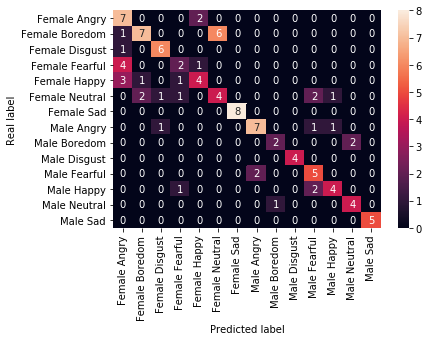

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Accuracy: 74.76635514018692
                precision    recall  f1-score   support

  Female Angry       0.50      0.78      0.61         9
Female Boredom       0.78      1.00      0.88        14
Female Disgust       1.00      1.00      1.00         7
Female Fearful       0.67      0.57      0.62         7
  Female Happy       0.67      0.44      0.53         9
Female Neutral       1.00      0.64      0.78        11
    Female Sad       1.00      1.00      1.00         8
    Male Angry       0.82      0.90      0.86        10
  Male Boredom       1.00      0.50      0.67         4
  Male Disgust       0.00      0.00      0.00         4
  Male Fearful       0.55

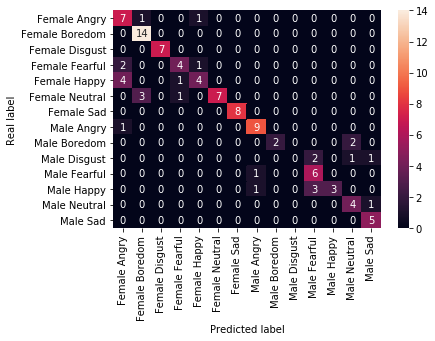

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 

Accuracy: 42.99065420560748
                precision    recall  f1-score   support

  Female Angry       0.60      0.67      0.63         9
Female Boredom       0.60      0.64      0.62        14
Female Disgust       0.50      0.29      0.36         7
Female Fearful       0.29      0.29      0.29         7
  Female Happy       0.36      0.56      0.43         9
Female Neutral       0.50      0.45      0.48        11
    Female Sad       0.80      0.50      0.62         8
    Male Angry       0.57      0.40      0.47        10
  Male Boredom       0.40      0.50   

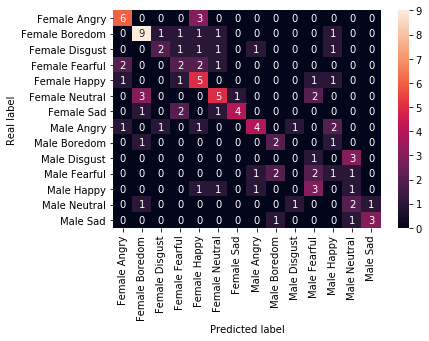

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Accuracy: 73.83177570093457
                precision    recall  f1-score   support

  Female Angry       0.50      0.89      0.64         9
Female Boredom       0.81      0.93      0.87        14
Female Disgust       0.86      0.86      0.86         7
Female Fearful       0.71      0.71      0.71         7
  Female Happy       0.50      0.22      0.31         9
Female Neutral       1.00      0.55      0.71        11
    Female Sad       0.89     

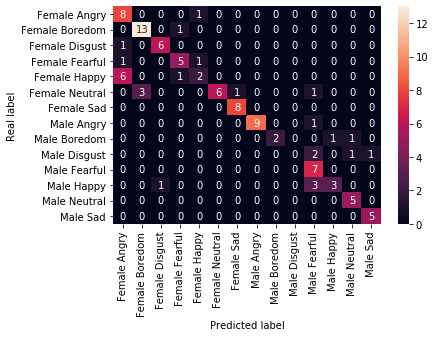

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

Accuracy: 70.09345794392523
                precision    recall  f1-score   support

  Female Angry       0.50      1.00      0.67         9
Female Boredom       0.80      0.86      0.83        14
Female Disgust       0.60      0.86      0.71         7
Female Fearful       0.67      0.57      0.62         7
  Female Happy       0.67      0.22      0.33         9
Female Neutral       0.86      0.55      0.67        11
    Female Sad       0.89      1.00      0.94         8
    Male Angry       0.82      0.90      0.86        10
  Male Boredom       1.00      0.75      0.86         4
  Male Disgust       0.00      0.00      0.00         4
  Male Fearful       0.50      0.86      0.63         7
    Male Happy       0.00      0.00      0.00  

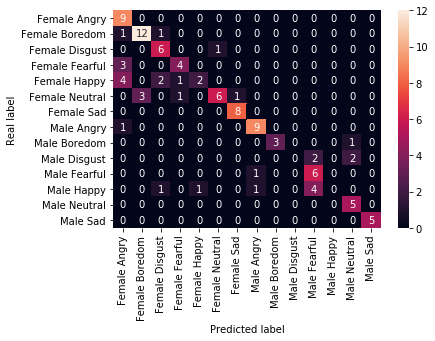

In [31]:
speech_encoder = LabelEncoder()
models =  implement_machine_learning(all_features_emo,all_labels_emo,speech_encoder)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

Accuracy: 75.70093457943925
                precision    recall  f1-score   support

  Female Angry       0.67      0.67      0.67         9
Female Boredom       0.92      0.79      0.85        14
Female Disgust       0.70      1.00      0.82         7
Female Fearful       0.70      1.00      0.82         7
  Female Happy       0.57      0.44      0.50         9
Female Neutral       0.70      0.64      0.67        11
    Female Sad       1.00      1.00      1.00         8
    Male Angry       0.77      1.00      0.87        10
  Male Boredom       0.67      0.50      0.57         4
  Male Disgust       0.75      0.75      0.75         4
  Male Fearful       0.80      0.57      0.67         7
    Male Happy       1.00      0.57      0.73         7
  Male Neutral       0.60      0.60      0.60         

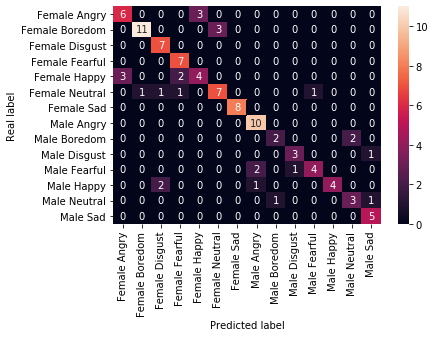

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Accuracy: 64.48598130841121
                precision    recall  f1-score   support

  Female Angry       0.60      1.00      0.75         9
Female Boredom       0.79      0.79      0.79        14
Female Disgust       0.75      0.86      0.80         7
Female Fearful       0.75      0.86      0.80         7
  Female Happy       1.00      0.44      0.62         9
Female Neutral       0.56      0.45      0.50        11
    Female Sad       1.00      0.88      0.93         8
    Male Angry       0.57      0.80      0.67        10
  Male Boredom       0.29      0.50      0.36         4
  Male Disgust       0.00      0.00      0.00         4
  Male Fearful       0.33

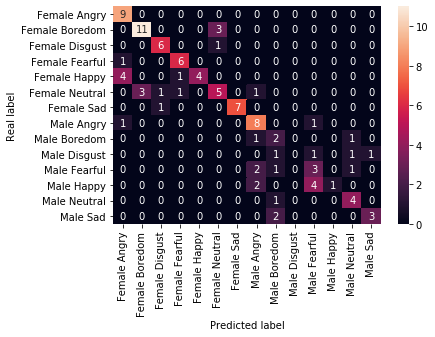

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 

Accuracy: 60.747663551401864
                precision    recall  f1-score   support

  Female Angry       0.78      0.78      0.78         9
Female Boredom       0.56      0.64      0.60        14
Female Disgust       0.46      0.86      0.60         7
Female Fearful       0.71      0.71      0.71         7
  Female Happy       0.67      0.44      0.53         9
Female Neutral       0.88      0.64      0.74        11
    Female Sad       0.64      0.88      0.74         8
    Male Angry       0.86      0.60      0.71        10
  Male Boredom       0.25      0.25  

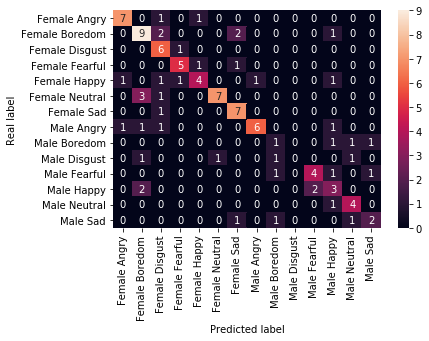

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Accuracy: 74.76635514018692
                precision    recall  f1-score   support

  Female Angry       0.60      1.00      0.75         9
Female Boredom       0.80      0.86      0.83        14
Female Disgust       0.88      1.00      0.93         7
Female Fearful       0.67      0.57      0.62         7
  Female Happy       0.67      0.44      0.53         9
Female Neutral       0.75      0.55      0.63        11
    Female Sad       1.00     

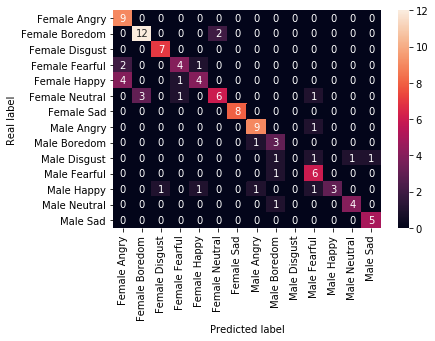

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

Accuracy: 72.89719626168224
                precision    recall  f1-score   support

  Female Angry       0.69      1.00      0.82         9
Female Boredom       0.77      0.71      0.74        14
Female Disgust       0.70      1.00      0.82         7
Female Fearful       0.78      1.00      0.88         7
  Female Happy       1.00      0.44      0.62         9
Female Neutral       0.70      0.64      0.67        11
    Female Sad       1.00      0.88      0.93         8
    Male Angry       0.82      0.90      0.86        10
  Male Boredom       0.38      0.75      0.50         4
  Male Disgust       0.00      0.00      0.00         4
  Male Fearful       0.56      0.71      0.63         7
    Male Happy       1.00      0.43      0.60  

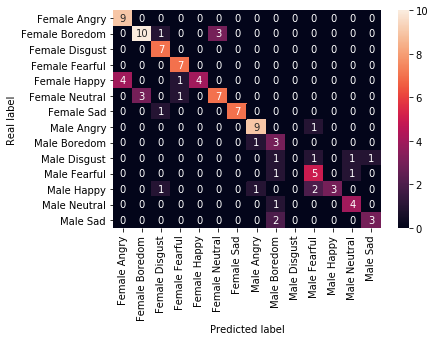

In [32]:
models_mfccs =  implement_machine_learning(all_mfccs_emo,all_labels_emo,speech_encoder)

In [33]:
encoder = LabelEncoder()
all_labels_emo = encoder.fit_transform(all_labels_emo)
no_labels_emo = len(np.unique(all_labels_emo))

Train on 363 samples, validate on 65 samples
Epoch 1/200
363/363 [==============================] - 1s 4ms/step - loss: 2.4108 - accuracy: 0.2011 - val_loss: 2.1631 - val_accuracy: 0.3077
Epoch 2/200
363/363 [==============================] - 0s 585us/step - loss: 1.7073 - accuracy: 0.4077 - val_loss: 1.7713 - val_accuracy: 0.3231
Epoch 3/200
363/363 [==============================] - 0s 584us/step - loss: 1.3626 - accuracy: 0.4931 - val_loss: 1.5396 - val_accuracy: 0.3846
Epoch 4/200
363/363 [==============================] - 0s 602us/step - loss: 1.1065 - accuracy: 0.5510 - val_loss: 1.3194 - val_accuracy: 0.4769
Epoch 5/200
363/363 [==============================] - 0s 602us/step - loss: 1.0030 - accuracy: 0.6116 - val_loss: 1.2875 - val_accuracy: 0.5231
Epoch 6/200
363/363 [==============================] - 0s 638us/step - loss: 0.8321 - accuracy: 0.6777 - val_loss: 1.1051 - val_accuracy: 0.5538
Epoch 7/200
363/363 [==============================] - 0s 643us/step - loss: 0.7405 - a

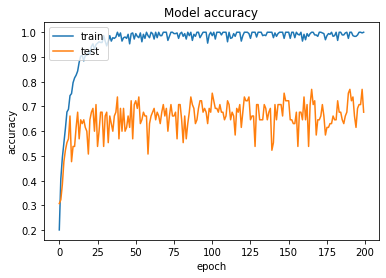

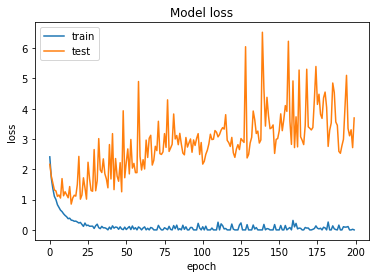

107/107 [==============================] - 0s 547us/step


In [34]:
transformed_labels = to_categorical(all_labels_emo,num_classes = no_labels_emo)
    
ff_all_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('All extracted features',
                                                           all_features_emo,no_features_emo,no_labels_emo)

In [35]:
predictions = encoder.inverse_transform(predicts)
predict_df = pd.DataFrame(predictions,columns=['Predicted values'])
actualvalues = speech_encoder.inverse_transform((realValues))
real_df = pd.DataFrame(actualvalues,columns=['Actual values'])
final_result_df = real_df.join(predict_df)
final_result_df.head(30)

Actual values Predicted values
0       Male Angry       Male Angry
1   Female Disgust   Female Disgust
2       Female Sad       Female Sad
3   Female Boredom   Female Boredom
4   Female Disgust   Female Disgust
5   Female Boredom   Female Neutral
6     Male Boredom     Male Boredom
7       Male Happy       Male Happy
8     Male Neutral     Male Boredom
9       Male Happy       Male Happy
10  Female Disgust       Female Sad
11      Male Angry       Male Angry
12    Female Happy     Female Happy
13  Female Fearful   Female Fearful
14        Male Sad         Male Sad
15    Female Angry     Female Angry
16    Female Happy     Female Happy
17      Female Sad       Female Sad
18  Female Fearful   Female Fearful
19        Male Sad         Male Sad
20  Female Neutral   Female Boredom
21      Female Sad       Female Sad
22    Female Angry     Female Angry
23    Male Neutral     Male Neutral
24  Female Disgust   Female Disgust
25      Female Sad       Female Sad
26      Female Sad       Female Sad
27        Male Sad         Male Sad
28    Male Boredom     Male Fearful
29  Female Boredom   Female Boredom

In [36]:
final_result_df.to_csv('Emodb_ActualvsPredicted.csv',index=False)

Train on 363 samples, validate on 65 samples
Epoch 1/200
363/363 [==============================] - 1s 2ms/step - loss: 2.4129 - accuracy: 0.2231 - val_loss: 2.1549 - val_accuracy: 0.2000
Epoch 2/200
363/363 [==============================] - 0s 573us/step - loss: 1.8648 - accuracy: 0.3168 - val_loss: 1.9495 - val_accuracy: 0.2000
Epoch 3/200
363/363 [==============================] - 0s 590us/step - loss: 1.6068 - accuracy: 0.3636 - val_loss: 1.5694 - val_accuracy: 0.3385
Epoch 4/200
363/363 [==============================] - 0s 606us/step - loss: 1.4110 - accuracy: 0.4463 - val_loss: 1.6748 - val_accuracy: 0.3077
Epoch 5/200
363/363 [==============================] - 0s 580us/step - loss: 1.2852 - accuracy: 0.5096 - val_loss: 1.7587 - val_accuracy: 0.3385
Epoch 6/200
363/363 [==============================] - 0s 580us/step - loss: 1.2134 - accuracy: 0.5372 - val_loss: 1.3845 - val_accuracy: 0.4615
Epoch 7/200
363/363 [==============================] - 0s 588us/step - loss: 1.0849 - a

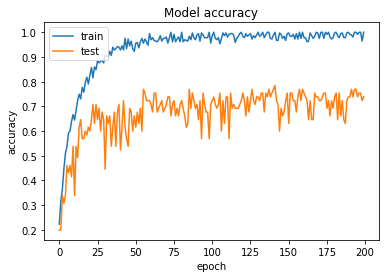

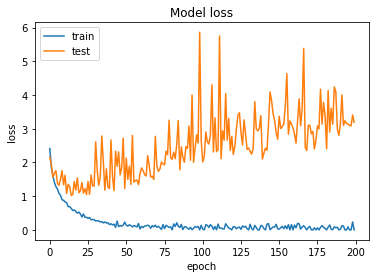

107/107 [==============================] - 0s 522us/step


In [37]:
ff_mffc_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('Mfccs',all_mfccs_emo,mfcc_no_features_emo,no_labels_emo)

Train on 363 samples, validate on 65 samples
Epoch 1/200
363/363 [==============================] - 1s 2ms/step - loss: 2.3979 - accuracy: 0.2011 - val_loss: 2.2458 - val_accuracy: 0.2615
Epoch 2/200
363/363 [==============================] - 0s 538us/step - loss: 1.9696 - accuracy: 0.3609 - val_loss: 2.0781 - val_accuracy: 0.2615
Epoch 3/200
363/363 [==============================] - 0s 596us/step - loss: 1.6448 - accuracy: 0.4325 - val_loss: 2.1314 - val_accuracy: 0.2462
Epoch 4/200
363/363 [==============================] - 0s 606us/step - loss: 1.3984 - accuracy: 0.4821 - val_loss: 1.5223 - val_accuracy: 0.4000
Epoch 5/200
363/363 [==============================] - 0s 609us/step - loss: 1.2386 - accuracy: 0.5069 - val_loss: 1.6807 - val_accuracy: 0.4308
Epoch 6/200
363/363 [==============================] - 0s 605us/step - loss: 1.0599 - accuracy: 0.6281 - val_loss: 1.3948 - val_accuracy: 0.4462
Epoch 7/200
363/363 [==============================] - 0s 612us/step - loss: 0.9183 - a

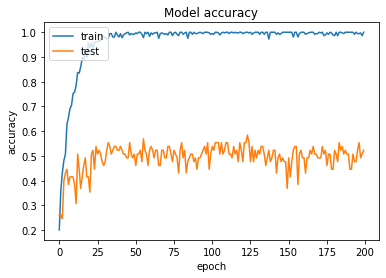

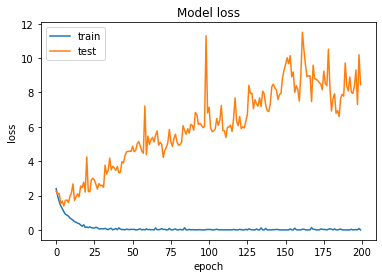

107/107 [==============================] - 0s 531us/step


In [38]:
ff_mel_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('Mels',all_mel_emo,mel_no_features_emo,no_labels_emo)

Train on 363 samples, validate on 65 samples
Epoch 1/200
363/363 [==============================] - 1s 2ms/step - loss: 2.6076 - accuracy: 0.1157 - val_loss: 2.6304 - val_accuracy: 0.0615
Epoch 2/200
363/363 [==============================] - 0s 523us/step - loss: 2.5389 - accuracy: 0.1377 - val_loss: 2.5623 - val_accuracy: 0.0769
Epoch 3/200
363/363 [==============================] - 0s 561us/step - loss: 2.4429 - accuracy: 0.1928 - val_loss: 2.4953 - val_accuracy: 0.1692
Epoch 4/200
363/363 [==============================] - 0s 581us/step - loss: 2.3457 - accuracy: 0.1873 - val_loss: 2.4063 - val_accuracy: 0.1692
Epoch 5/200
363/363 [==============================] - 0s 564us/step - loss: 2.2783 - accuracy: 0.2039 - val_loss: 2.3118 - val_accuracy: 0.2462
Epoch 6/200
363/363 [==============================] - 0s 567us/step - loss: 2.2076 - accuracy: 0.2231 - val_loss: 2.7181 - val_accuracy: 0.1538
Epoch 7/200
363/363 [==============================] - 0s 574us/step - loss: 2.1437 - a

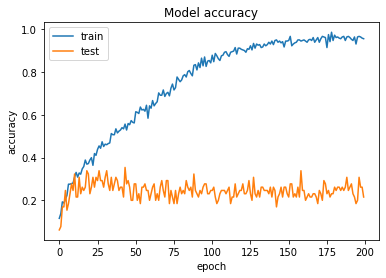

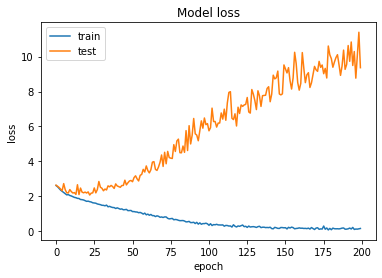

107/107 [==============================] - 0s 616us/step


In [39]:
ff_chroma_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('Chromas',all_chroma_emo,chroma_no_features_emo,no_labels_emo)

Test the models

In [41]:
audio_file_emo = 'D:/Desktop/emodb/wav/03a02Wb.wav'
sampling_frequency_emo,bit_depth_emo,no_channels = verify_properties_of_audio(audio_file_emo)
sampling_frequency_emo,bit_depth_emo,no_channels

(16000, 2, 1)

In [42]:
import IPython
IPython.display.Audio(audio_file_emo, rate=sampling_frequency_emo)

In [43]:
def get_label(audio_file):
    path, file = os.path.split(audio_file_emo)
    sintax_gender = file[:2]
    if sintax_gender in ('08','09','13','14','16'):
        gender = 'Female '
    else:
        gender = 'Male '
        
    # get the emotion
    audio = os.path.splitext(file)[0]

    emotion = get_key_from_dict(emotions, audio[-2])
    label = gender+emotion
    
    return label

In [44]:
mfcc_file,chroma_file,mel_file = extract_features(audio_file_emo)
file_label = get_label(audio_file_emo)

In [45]:
for m in models:
    mfcc_file,chroma_file,mel_file = extract_features(audio_file_emo)
    file_label = get_label(audio_file_emo)
    features = []
    features = np.hstack((mfcc_file,chroma_file,mel_file)).ravel()
    features = features.reshape(-1,180)
    y_pred = m.predict(features)
    y_pred = speech_encoder.inverse_transform(y_pred)
    print(y_pred)

['Male Angry']
['Female Boredom']
['Female Boredom']
['Male Angry']
['Female Angry']


In [46]:
for m in models_mfccs:
    mfcc_file = mfcc_file.reshape(-1,40)
    y_pred = m.predict(mfcc_file)
    y_pred = speech_encoder.inverse_transform(y_pred)
    print(y_pred)

['Male Angry']
['Male Happy']
['Male Angry']
['Male Angry']
['Female Fearful']


In [50]:
pred = ff_mffc_model.predict(mfcc_file)
predi = pred.argmax(axis=1)
predictions = encoder.inverse_transform(predi)
predictions

array(['Female Happy'], dtype='<U14')

# RAVDESS

In [54]:
path = 'D:/Desktop/Ravdess'
all_mfccs_ravd, all_chroma_ravd, all_mel_ravd, all_labels_ravd = load_data(path)

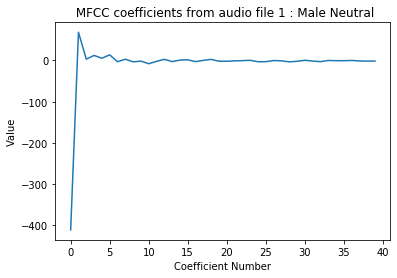

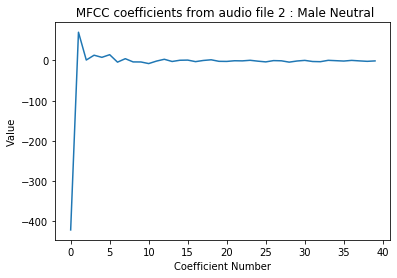

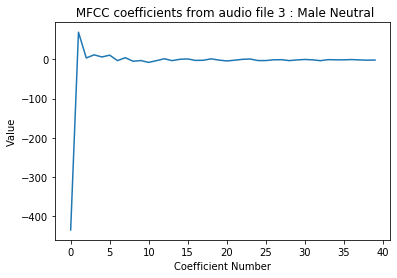

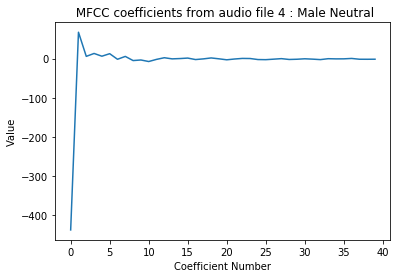

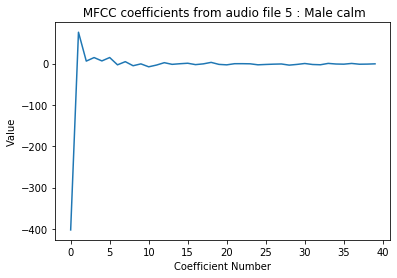

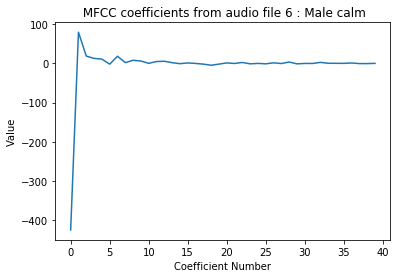

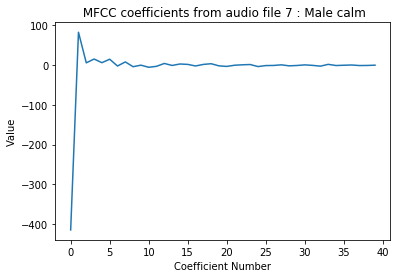

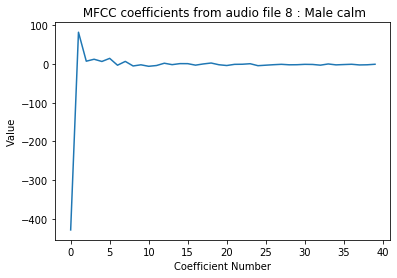

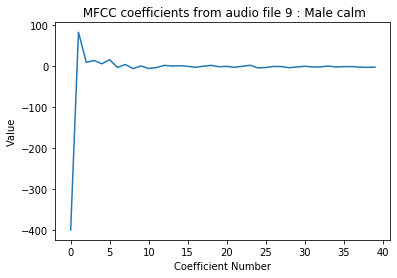

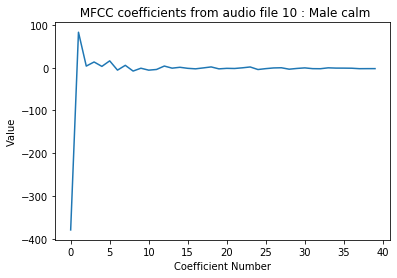

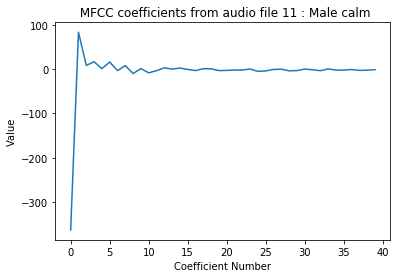

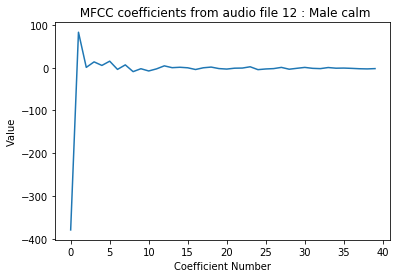

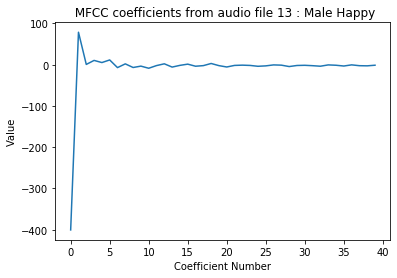

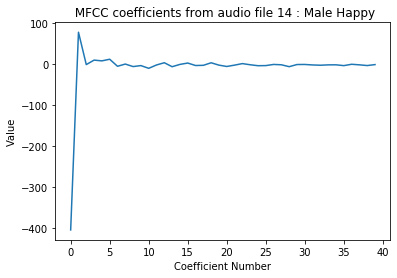

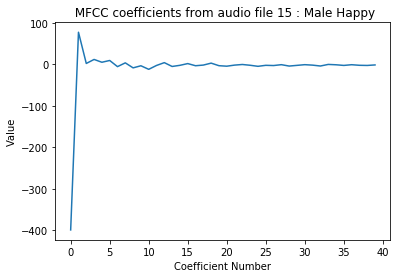

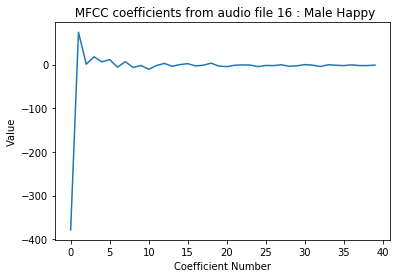

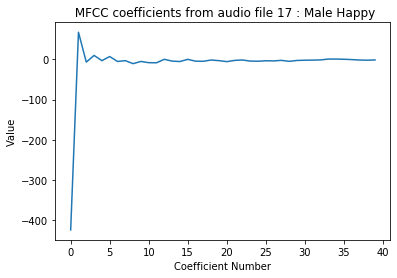

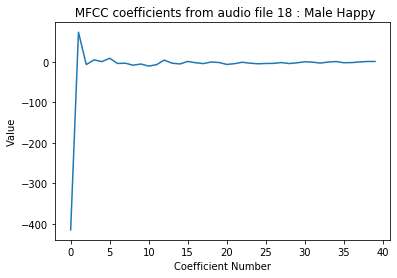

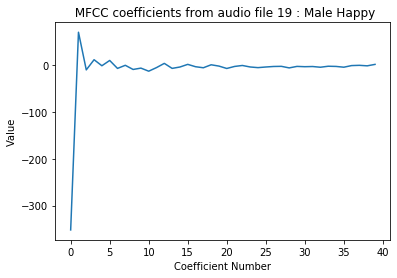

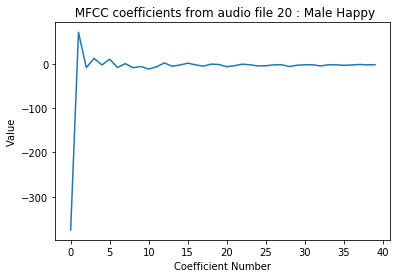

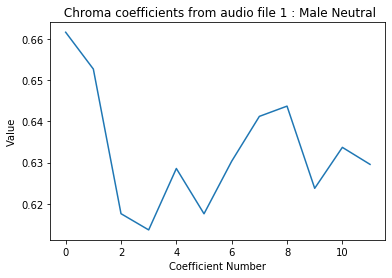

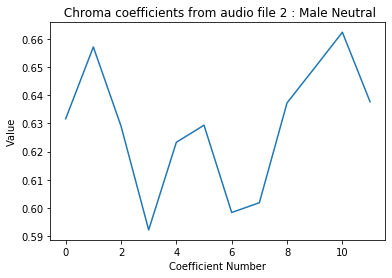

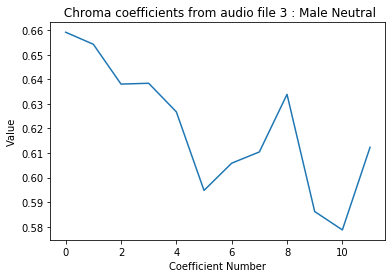

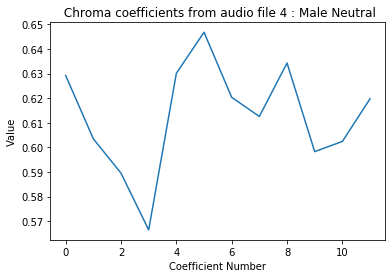

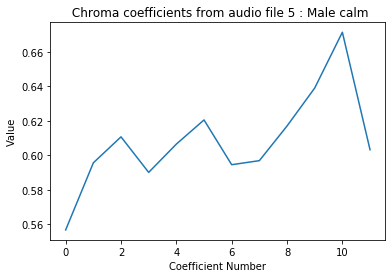

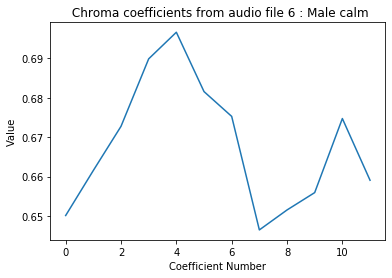

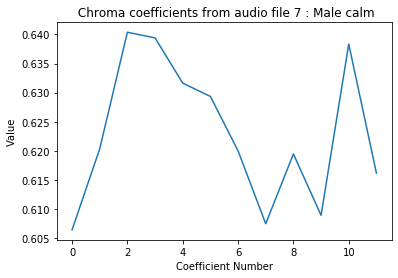

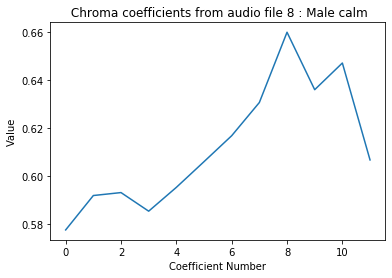

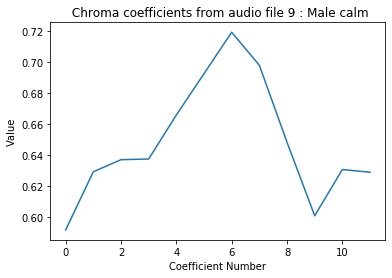

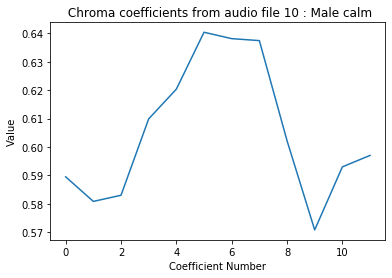

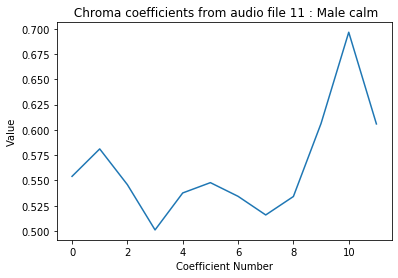

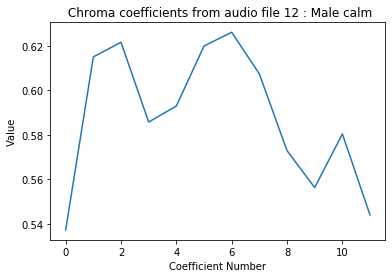

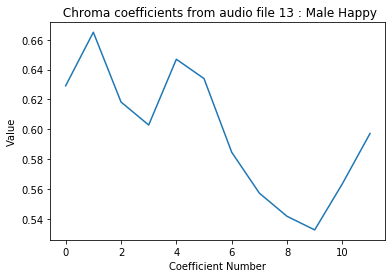

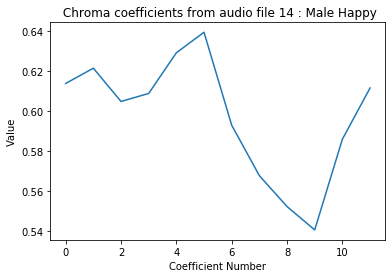

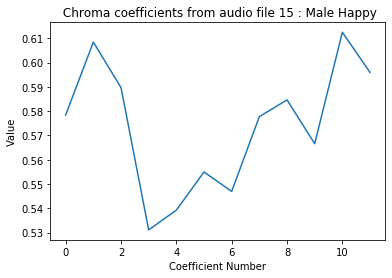

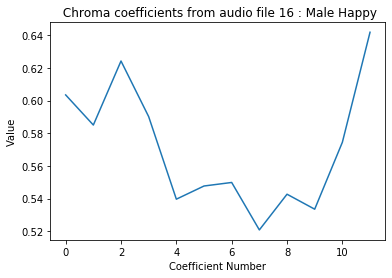

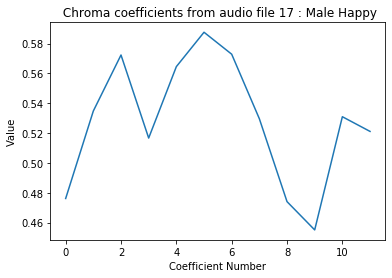

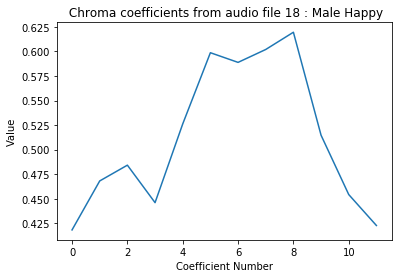

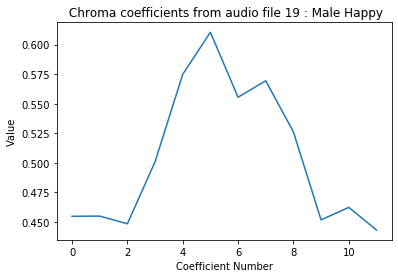

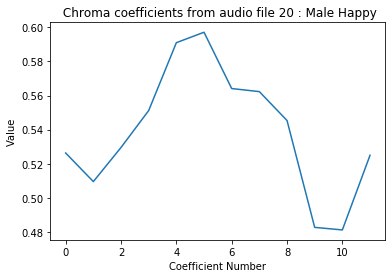

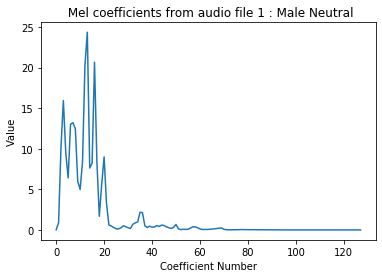

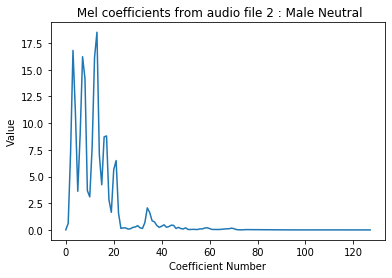

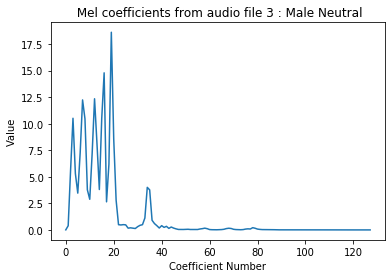

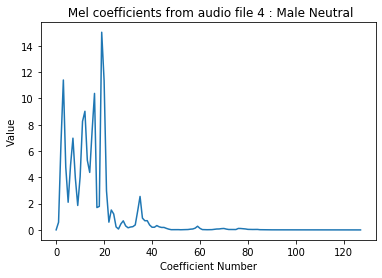

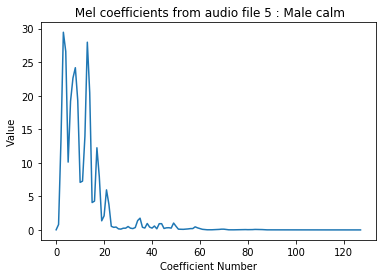

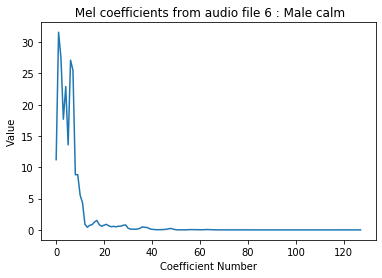

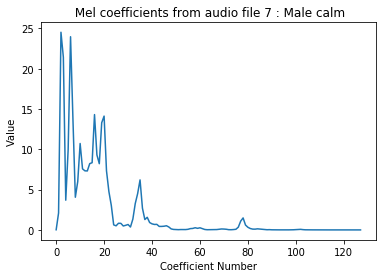

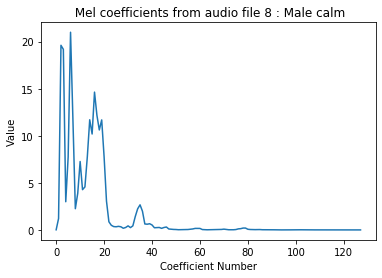

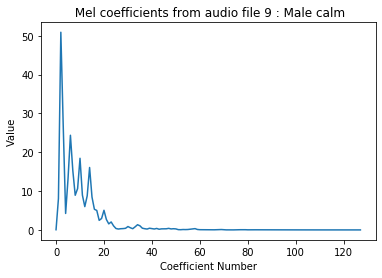

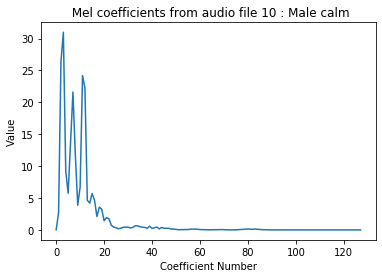

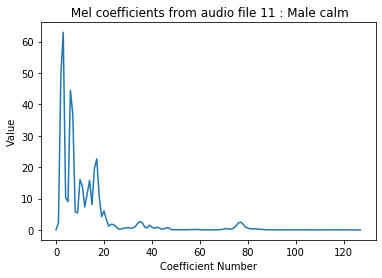

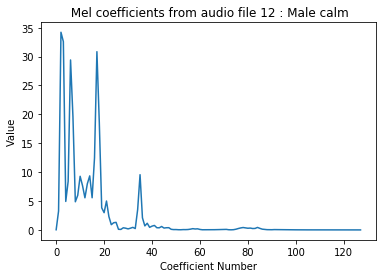

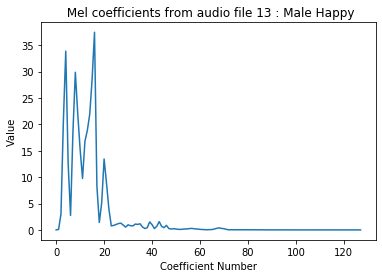

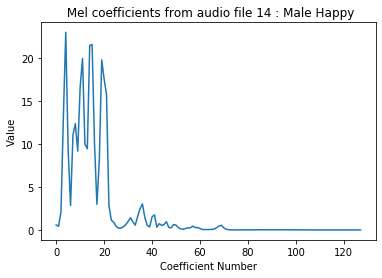

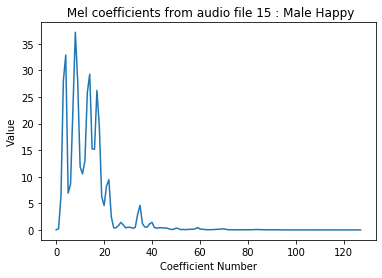

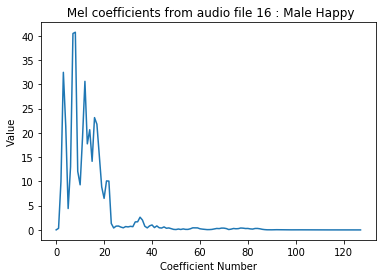

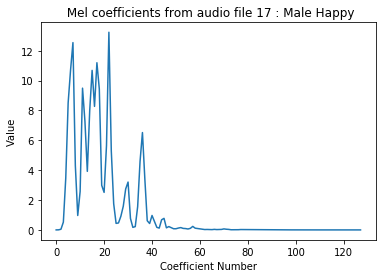

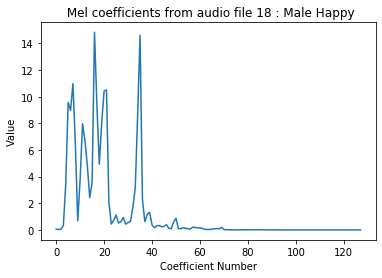

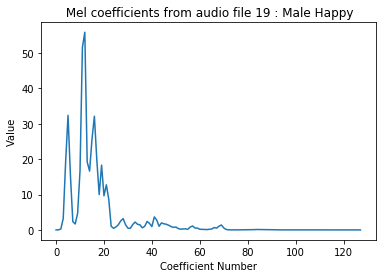

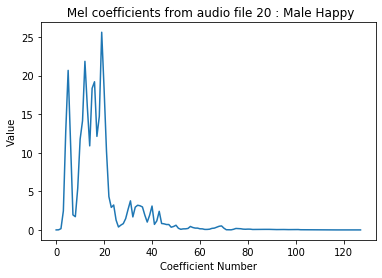

In [55]:
display_graphics(all_mfccs_ravd, all_chroma_ravd, all_mel_ravd, all_labels_ravd)

In [56]:
all_features_ravd = all_features_combined(all_mfccs_ravd.shape[0],all_mfccs_ravd, all_chroma_ravd, all_mel_ravd)

In [57]:
df_mfcc_ravd,df_chroma_ravd,df_mel_ravd = display_coeffcients_in_dataframe(all_features_ravd,all_mfccs_ravd, all_chroma_ravd, all_mel_ravd,all_labels_ravd)

The database contain: 2452 wav files
Each audio file has: 40 MFCCs features
Each audio file has: 12 Chromas features
Each audio file has: 128 Mels features


In [58]:
df_mfcc_ravd.head()

Feature 1 MFCCs  Feature 2 MFCCs  Feature 3 MFCCs  \
Audio_file1      -411.334534        68.541420         3.293398   
Audio_file2      -421.047119        70.202240         1.169073   
Audio_file3      -435.986511        69.690376         3.925557   
Audio_file4      -438.786072        67.579201         5.783356   
Audio_file5      -402.189331        75.788948         6.028997   

             Feature 4 MFCCs  Feature 5 MFCCs  Feature 6 MFCCs  \
Audio_file1        12.205298         5.510278        13.667405   
Audio_file2        13.123214         7.837617        14.411950   
Audio_file3        11.925323         6.423344        11.014112   
Audio_file4        13.227698         6.194668        12.640198   
Audio_file5        14.562723         6.459431        14.636640   

             Feature 7 MFCCs  Feature 8 MFCCs  Feature 9 MFCCs  \
Audio_file1        -2.983827         3.098028        -3.310813   
Audio_file2        -4.110704         4.469617        -3.538731   
Audio_file3        -2.874455         4.514385        -4.470305   
Audio_file4        -1.662046         5.663979        -4.953694   
Audio_file5        -2.999553         4.625812        -5.195350   

             Feature 10 MFCCs  ...  Feature 32 MFCCs  Feature 33 MFCCs  \
Audio_file1         -1.564385  ...         -1.399109         -2.926856   
Audio_file2         -3.657982  ...         -2.521299         -2.987527   
Audio_file3         -2.665094  ...         -0.909865         -3.046812   
Audio_file4         -3.484669  ...         -1.325091         -2.506734   
Audio_file5         -0.702962  ...         -2.190074         -2.837189   

             Feature 34 MFCCs  Feature 35 MFCCs  Feature 36 MFCCs  \
Audio_file1          0.013957         -0.490734         -0.570906   
Audio_file2          0.409853         -0.484092         -1.398325   
Audio_file3         -0.374433         -0.850618         -0.923815   
Audio_file4         -0.183847         -0.639693         -0.547448   
Audio_file5          0.461874         -1.021207         -1.413634   

             Feature 37 MFCCs  Feature 38 MFCCs  Feature 39 MFCCs  \
Audio_file1          0.040399         -1.207217         -1.594982   
Audio_file2          0.255243         -0.984965         -2.093073   
Audio_file3         -0.172054         -1.145952         -1.726803   
Audio_file4          0.465640         -1.572787         -1.638370   
Audio_file5          0.348100         -1.522349         -1.252681   

             Feature 40 MFCCs       Emotion  
Audio_file1         -1.436487  Male Neutral  
Audio_file2         -1.040829  Male Neutral  
Audio_file3         -1.451421  Male Neutral  
Audio_file4         -1.501148  Male Neutral  
Audio_file5         -0.616518     Male calm  

[5 rows x 41 columns]

In [59]:
df_chroma_ravd.head()

Feature 1 Chromas  Feature 2 Chromas  Feature 3 Chromas  \
Audio_file1           0.661632           0.652701           0.617600   
Audio_file2           0.631670           0.657217           0.629099   
Audio_file3           0.659189           0.654299           0.638083   
Audio_file4           0.629244           0.603477           0.589504   
Audio_file5           0.556746           0.595652           0.610718   

             Feature 4 Chromas  Feature 5 Chromas  Feature 6 Chromas  \
Audio_file1           0.613662           0.628567           0.617574   
Audio_file2           0.592149           0.623314           0.629390   
Audio_file3           0.638414           0.626768           0.594788   
Audio_file4           0.566401           0.630134           0.646848   
Audio_file5           0.590107           0.606515           0.620526   

             Feature 7 Chromas  Feature 8 Chromas  Feature 9 Chromas  \
Audio_file1           0.630331           0.641214           0.643701   
Audio_file2           0.598345           0.601823           0.637317   
Audio_file3           0.605879           0.610453           0.633893   
Audio_file4           0.620364           0.612580           0.634324   
Audio_file5           0.594567           0.596909           0.617004   

             Feature 10 Chromas  Feature 11 Chromas  Feature 12 Chromas  \
Audio_file1            0.623758            0.633696            0.629568   
Audio_file2            0.649816            0.662454            0.637759   
Audio_file3            0.586193            0.578705            0.612331   
Audio_file4            0.598264            0.602408            0.619763   
Audio_file5            0.639014            0.671381            0.603249   

                  Emotion  
Audio_file1  Male Neutral  
Audio_file2  Male Neutral  
Audio_file3  Male Neutral  
Audio_file4  Male Neutral  
Audio_file5     Male calm

In [60]:
df_mel_ravd.head()

Feature 1 Mels  Feature 2 Mels  Feature 3 Mels  Feature 4 Mels  \
Audio_file1        0.010330        0.869450       10.090516       15.938281   
Audio_file2        0.009501        0.611622        7.252008       16.807713   
Audio_file3        0.006400        0.392871        5.638850       10.512442   
Audio_file4        0.005391        0.583344        6.569137       11.400632   
Audio_file5        0.019539        0.805723       13.320057       29.459978   

             Feature 5 Mels  Feature 6 Mels  Feature 7 Mels  Feature 8 Mels  \
Audio_file1        9.550491        6.414325       13.019916       13.205542   
Audio_file2       11.077249        3.616709        8.972324       16.217979   
Audio_file3        5.303628        3.463740        7.250215       12.240558   
Audio_file4        4.787640        2.103356        4.918744        6.976018   
Audio_file5       26.599453       10.105797       19.183735       22.620790   

             Feature 9 Mels  Feature 10 Mels  ...  Feature 120 Mels  \
Audio_file1       12.458400         5.986904  ...          0.000161   
Audio_file2       14.167649         3.678606  ...          0.000117   
Audio_file3       10.458234         3.774103  ...          0.000142   
Audio_file4        3.945302         1.859651  ...          0.000261   
Audio_file5       24.176611        19.307280  ...          0.000158   

             Feature 121 Mels  Feature 122 Mels  Feature 123 Mels  \
Audio_file1          0.000082          0.000039          0.000025   
Audio_file2          0.000074          0.000036          0.000024   
Audio_file3          0.000120          0.000074          0.000084   
Audio_file4          0.000250          0.000262          0.000142   
Audio_file5          0.000134          0.000073          0.000045   

             Feature 124 Mels  Feature 125 Mels  Feature 126 Mels  \
Audio_file1          0.000017          0.000014          0.000007   
Audio_file2          0.000018          0.000012          0.000009   
Audio_file3          0.000090          0.000095          0.000054   
Audio_file4          0.000074          0.000030          0.000010   
Audio_file5          0.000027          0.000016          0.000010   

             Feature 127 Mels  Feature 128 Mels       Emotion  
Audio_file1          0.000004          0.000003  Male Neutral  
Audio_file2          0.000003          0.000002  Male Neutral  
Audio_file3          0.000008          0.000002  Male Neutral  
Audio_file4          0.000002          0.000001  Male Neutral  
Audio_file5          0.000009          0.000008     Male calm  

[5 rows x 129 columns]

In [61]:
ravdess_speech_dataframe = create_csv_file(df_mfcc_ravd,df_chroma_ravd,df_mel_ravd)
ravdess_speech_dataframe.to_csv('RavdessSpeech.csv')

In [62]:
ravdess_speech_dataframe.head()

Feature 1 MFCCs  Feature 2 MFCCs  Feature 3 MFCCs  \
Audio_file1      -411.334534        68.541420         3.293398   
Audio_file2      -421.047119        70.202240         1.169073   
Audio_file3      -435.986511        69.690376         3.925557   
Audio_file4      -438.786072        67.579201         5.783356   
Audio_file5      -402.189331        75.788948         6.028997   

             Feature 4 MFCCs  Feature 5 MFCCs  Feature 6 MFCCs  \
Audio_file1        12.205298         5.510278        13.667405   
Audio_file2        13.123214         7.837617        14.411950   
Audio_file3        11.925323         6.423344        11.014112   
Audio_file4        13.227698         6.194668        12.640198   
Audio_file5        14.562723         6.459431        14.636640   

             Feature 7 MFCCs  Feature 8 MFCCs  Feature 9 MFCCs  \
Audio_file1        -2.983827         3.098028        -3.310813   
Audio_file2        -4.110704         4.469617        -3.538731   
Audio_file3        -2.874455         4.514385        -4.470305   
Audio_file4        -1.662046         5.663979        -4.953694   
Audio_file5        -2.999553         4.625812        -5.195350   

             Feature 10 MFCCs  ...  Feature 120 Mels  Feature 121 Mels  \
Audio_file1         -1.564385  ...          0.000161          0.000082   
Audio_file2         -3.657982  ...          0.000117          0.000074   
Audio_file3         -2.665094  ...          0.000142          0.000120   
Audio_file4         -3.484669  ...          0.000261          0.000250   
Audio_file5         -0.702962  ...          0.000158          0.000134   

             Feature 122 Mels  Feature 123 Mels  Feature 124 Mels  \
Audio_file1          0.000039          0.000025          0.000017   
Audio_file2          0.000036          0.000024          0.000018   
Audio_file3          0.000074          0.000084          0.000090   
Audio_file4          0.000262          0.000142          0.000074   
Audio_file5          0.000073          0.000045          0.000027   

             Feature 125 Mels  Feature 126 Mels  Feature 127 Mels  \
Audio_file1          0.000014          0.000007          0.000004   
Audio_file2          0.000012          0.000009          0.000003   
Audio_file3          0.000095          0.000054          0.000008   
Audio_file4          0.000030          0.000010          0.000002   
Audio_file5          0.000016          0.000010          0.000009   

             Feature 128 Mels       Emotion  
Audio_file1          0.000003  Male Neutral  
Audio_file2          0.000002  Male Neutral  
Audio_file3          0.000002  Male Neutral  
Audio_file4          0.000001  Male Neutral  
Audio_file5          0.000008     Male calm  

[5 rows x 181 columns]

In [63]:
all_mfccs_ravd, all_chroma_ravd, all_mel_ravd, all_features_ravd = normalize_data(all_mfccs_ravd, all_chroma_ravd, all_mel_ravd, all_features_ravd)
no_features_ravd = all_features_ravd.shape[1]
mfcc_no_features_ravd = all_mfccs_ravd.shape[1]
chroma_no_features_ravd = all_chroma_ravd.shape[1]
mel_no_features_ravd = all_mel_ravd.shape[1]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

Accuracy: 72.09775967413442
                  precision    recall  f1-score   support

    Female Angry       0.79      0.85      0.81        26
  Female Disgust       0.55      0.48      0.51        23
  Female Fearful       0.72      0.78      0.75        36
    Female Happy       0.63      0.73      0.68        30
  Female Neutral       0.67      0.64      0.65        22
      Female Sad       0.73      0.60      0.66        40
     Female calm       0.87      0.82      0.85        40
Female surprised       0.50      0.64      0.56        14
      Male Angry       0.83      0.74      0.78        34
    Male Disgust       0.68      0.68      0.68        22
    Male Fearful       0.72      0.76      0.74        37
      Male Happy       0.74      0.70      0.72        37
    Male Neutral       0.76 

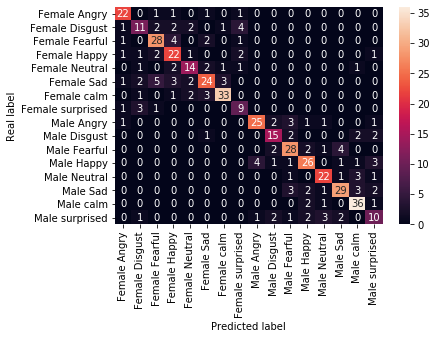

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Accuracy: 60.4887983706721
                  precision    recall  f1-score   support

    Female Angry       0.55      0.85      0.67        26
  Female Disgust       0.69      0.48      0.56        23
  Female Fearful       0.63      0.67      0.65        36
    Female Happy       0.69      0.80      0.74        30
  Female Neutral       0.86      0.55      0.67        22
      Female Sad       0.68      0.53      0.59        40
     Female calm       0.72      0.82      0.77        40
Female surprised       0.36      0.29      0.32        14
      Male Angry       0.60      0.76      0.68        34
    Male Disgust       0.62      0.45      0.53        22
    

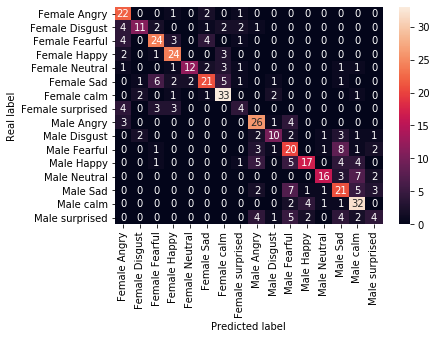

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 

Accuracy: 40.52953156822811
                  precision    recall  f1-score   support

    Female Angry       0.40      0.62      0.48        26
  Female Disgust       0.29      0.22      0.25        23
  Female Fearful       0.39      0.36      0.38        36
    Female Happy       0.23      0.23      0.23        30
  Female Neutral       0.58      0.50      0.54        22
      Female Sad       0.48      0.40      0.44        40
     Female calm       0.55      0.57      0.56        40
Female surprised       0.35      0.50      0.41        14
      Male Angry    

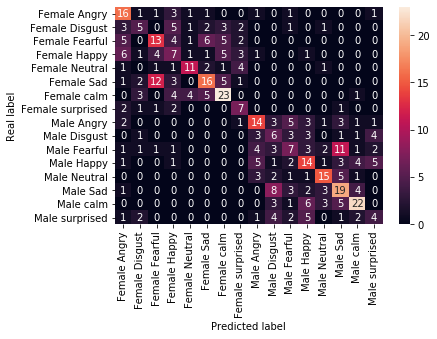

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Accuracy: 67.20977596741345
                  precision    recall  f1-score   support

    Female Angry       0.65      0.92      0.76        26
  Female Disgust       0.57      0.35      0.43        23
  Female Fearful       0.66      0.81      0.73        36
    Female Happy       0.71      0.73      0.72        30
  Female Neutral       0.93      0.59      0.72        22
      Female Sad       0.71      0.55      0.62        40
     Female calm

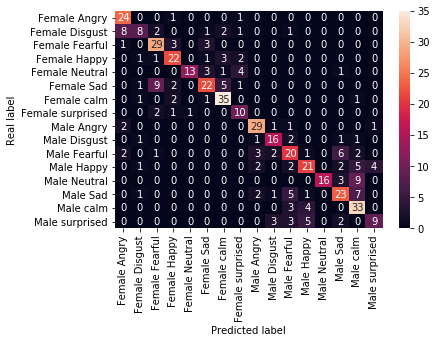

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

Accuracy: 53.97148676171079
                  precision    recall  f1-score   support

    Female Angry       0.42      0.85      0.56        26
  Female Disgust       0.50      0.48      0.49        23
  Female Fearful       0.61      0.64      0.62        36
    Female Happy       0.68      0.57      0.62        30
  Female Neutral       1.00      0.41      0.58        22
      Female Sad       0.74      0.57      0.65        40
     Female calm       0.75      0.82      0.79        40
Female surprised       0.18      0.14      0.16        14
      Male Angry       0.64      0.79      0.71        34
    Male Disgust       0.55      0.27      0.36        22
    Male Fearful       0.40      0.46      0.42        37
      Male Happy       

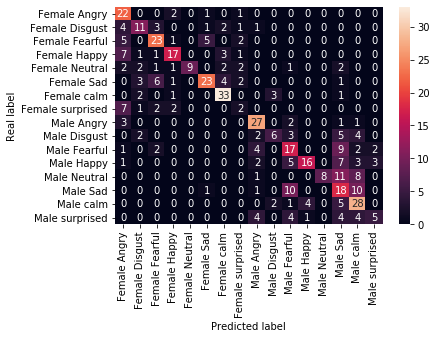

In [65]:
speech_encoder_ravd = LabelEncoder()
some_ml_models =  implement_machine_learning(all_features_ravd,all_labels_ravd,speech_encoder_ravd)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') 

Accuracy: 80.04073319755601
                  precision    recall  f1-score   support

    Female Angry       0.77      0.92      0.84        26
  Female Disgust       0.93      0.61      0.74        23
  Female Fearful       0.80      0.89      0.84        36
    Female Happy       0.63      0.80      0.71        30
  Female Neutral       0.77      0.91      0.83        22
      Female Sad       0.84      0.68      0.75        40
     Female calm       0.89      0.85      0.87        40
Female surprised       0.64      0.64      0.64        14
      Male Angry       0.89      0.91      0.90        34
    Male Disgust       0.81      0.59      0.68        22
    Male Fearful       0.83      0.81      0.82        37
      Male Happy       0.84      0.73      0.78        37
    Male Neutral       0.86 

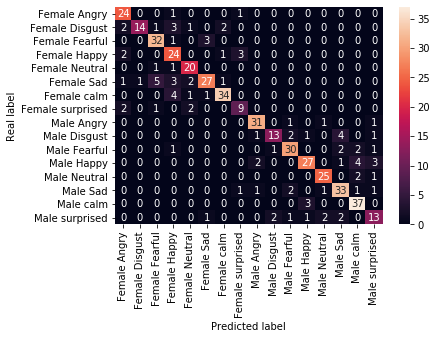

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Accuracy: 49.490835030549896
                  precision    recall  f1-score   support

    Female Angry       0.50      0.88      0.64        26
  Female Disgust       0.38      0.26      0.31        23
  Female Fearful       0.53      0.50      0.51        36
    Female Happy       0.55      0.53      0.54        30
  Female Neutral       0.91      0.45      0.61        22
      Female Sad       0.55      0.45      0.49        40
     Female calm       0.61      0.75      0.67        40
Female surprised       0.35      0.43      0.39        14
      Male Angry       0.66      0.74      0.69        34
    Male Disgust       0.44      0.18      0.26        22
  

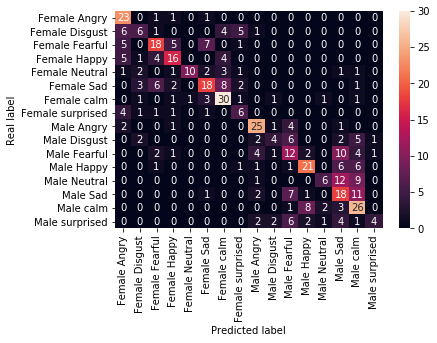

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 

Accuracy: 43.38085539714868
                  precision    recall  f1-score   support

    Female Angry       0.38      0.46      0.41        26
  Female Disgust       0.25      0.22      0.23        23
  Female Fearful       0.42      0.47      0.45        36
    Female Happy       0.45      0.47      0.46        30
  Female Neutral       0.57      0.55      0.56        22
      Female Sad       0.38      0.38      0.38        40
     Female calm       0.51      0.47      0.49        40
Female surprised       0.38      0.43      0.40        14
      Male Angry    

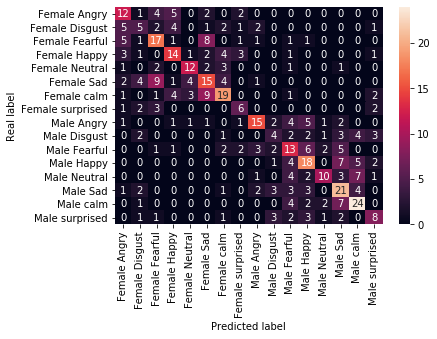

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Accuracy: 71.69042769857434
                  precision    recall  f1-score   support

    Female Angry       0.69      0.96      0.81        26
  Female Disgust       0.69      0.39      0.50        23
  Female Fearful       0.72      0.86      0.78        36
    Female Happy       0.79      0.73      0.76        30
  Female Neutral       0.92      0.50      0.65        22
      Female Sad       0.77      0.60      0.68        40
     Female calm

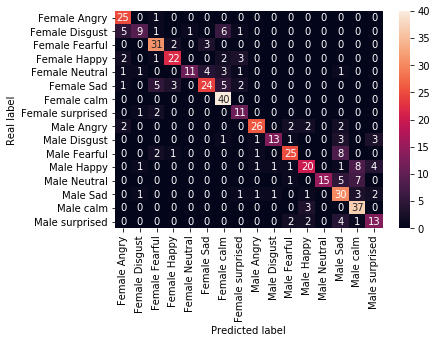

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

Accuracy: 68.63543788187373
                  precision    recall  f1-score   support

    Female Angry       0.80      0.92      0.86        26
  Female Disgust       0.75      0.52      0.62        23
  Female Fearful       0.70      0.86      0.78        36
    Female Happy       0.71      0.80      0.75        30
  Female Neutral       0.86      0.55      0.67        22
      Female Sad       0.81      0.53      0.64        40
     Female calm       0.75      0.95      0.84        40
Female surprised       0.57      0.86      0.69        14
      Male Angry       0.87      0.79      0.83        34
    Male Disgust       0.68      0.59      0.63        22
    Male Fearful       0.59      0.51      0.55        37
      Male Happy       

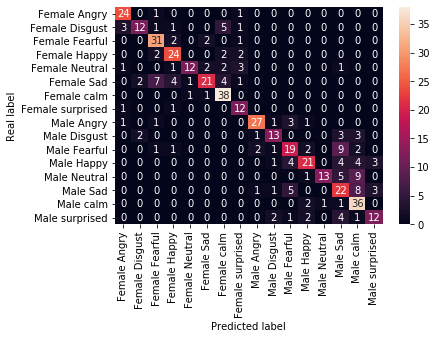

In [66]:
mfcc_encoder = LabelEncoder()
some_models =  implement_machine_learning(all_mfccs_ravd,all_labels_ravd,mfcc_encoder)

In [67]:
speech_encoder = LabelEncoder()
all_labels_ravd = speech_encoder.fit_transform(all_labels_ravd)
no_labels_ravd = len(np.unique(all_labels_ravd))

Train on 1666 samples, validate on 295 samples
Epoch 1/200
1666/1666 [==============================] - 1s 879us/step - loss: 2.3216 - accuracy: 0.1897 - val_loss: 1.9616 - val_accuracy: 0.2712
Epoch 2/200
1666/1666 [==============================] - 1s 606us/step - loss: 1.8800 - accuracy: 0.3133 - val_loss: 1.8074 - val_accuracy: 0.3153
Epoch 3/200
1666/1666 [==============================] - 1s 595us/step - loss: 1.6361 - accuracy: 0.3878 - val_loss: 1.6069 - val_accuracy: 0.3966
Epoch 4/200
1666/1666 [==============================] - 1s 608us/step - loss: 1.4701 - accuracy: 0.4622 - val_loss: 1.4175 - val_accuracy: 0.4780
Epoch 5/200
1666/1666 [==============================] - 1s 645us/step - loss: 1.3331 - accuracy: 0.5102 - val_loss: 1.3694 - val_accuracy: 0.4949
Epoch 6/200
1666/1666 [==============================] - 1s 565us/step - loss: 1.2011 - accuracy: 0.5648 - val_loss: 1.4437 - val_accuracy: 0.4542
Epoch 7/200
1666/1666 [==============================] - 1s 579us/step 

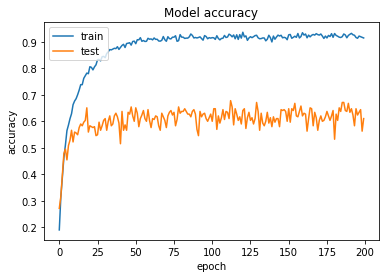

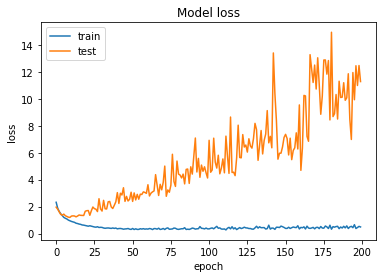

491/491 [==============================] - 0s 81us/step


In [68]:
transformed_labels = to_categorical(all_labels_ravd,num_classes = no_labels_ravd)
    
ff_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('All extracted features',all_features_ravd,no_features_ravd,no_labels_ravd)

In [69]:
predictions = (speech_encoder.inverse_transform(predicts))
predict_df = pd.DataFrame(predictions,columns=['Predicted values'])
actualvalues = (speech_encoder.inverse_transform((realValues)))
real_df = pd.DataFrame(actualvalues,columns=['Actual values'])
final_result_df = real_df.join(predict_df)
final_result_df.head(30)

Actual values  Predicted values
0         Male Happy    Male surprised
1         Male Happy        Male Happy
2       Female Happy      Female Happy
3         Male Happy        Male Happy
4       Male Fearful          Male Sad
5     Female Neutral  Female surprised
6        Female calm       Female calm
7       Female Happy      Female Happy
8         Male Angry        Male Happy
9     Male surprised      Male Disgust
10        Male Happy        Male Happy
11      Female Happy    Female Fearful
12      Male Fearful          Male Sad
13        Male Angry        Male Angry
14          Male Sad          Male Sad
15        Male Angry        Male Angry
16       Female calm       Female calm
17        Female Sad        Female Sad
18        Male Angry        Male Angry
19  Female surprised  Female surprised
20      Female Angry      Female Angry
21      Female Angry      Female Angry
22          Male Sad          Male Sad
23      Male Fearful        Female Sad
24         Male calm         Male calm
25       Female calm      Female Happy
26         Male calm        Male Happy
27       Female calm       Female calm
28      Female Happy      Female Happy
29      Male Fearful    Male surprised

In [70]:
final_result_df.to_csv('RavdessSpeech_ActualvsPredicted.csv',index=False)

Train on 1666 samples, validate on 295 samples
Epoch 1/200
1666/1666 [==============================] - 1s 439us/step - loss: 2.3772 - accuracy: 0.1513 - val_loss: 2.0947 - val_accuracy: 0.2441
Epoch 2/200
1666/1666 [==============================] - 1s 324us/step - loss: 1.9959 - accuracy: 0.2503 - val_loss: 1.8219 - val_accuracy: 0.2983
Epoch 3/200
1666/1666 [==============================] - 1s 321us/step - loss: 1.7446 - accuracy: 0.3265 - val_loss: 1.7524 - val_accuracy: 0.3085
Epoch 4/200
1666/1666 [==============================] - 1s 309us/step - loss: 1.5943 - accuracy: 0.3980 - val_loss: 1.4803 - val_accuracy: 0.4475
Epoch 5/200
1666/1666 [==============================] - 1s 330us/step - loss: 1.4850 - accuracy: 0.4514 - val_loss: 1.3577 - val_accuracy: 0.5017
Epoch 6/200
1666/1666 [==============================] - 1s 315us/step - loss: 1.3906 - accuracy: 0.4808 - val_loss: 1.6393 - val_accuracy: 0.4000
Epoch 7/200
1666/1666 [==============================] - 1s 303us/step 

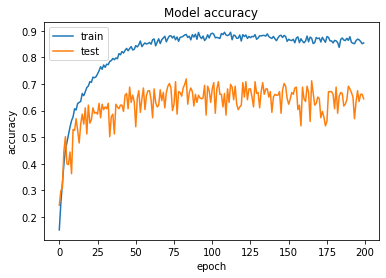

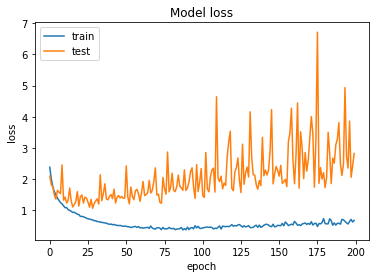

491/491 [==============================] - 0s 69us/step


In [71]:
mfcc_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('Mfccs',all_mfccs_ravd,mfcc_no_features_ravd,no_labels_ravd)

Train on 1666 samples, validate on 295 samples
Epoch 1/200
1666/1666 [==============================] - 1s 408us/step - loss: 2.2842 - accuracy: 0.2335 - val_loss: 2.1111 - val_accuracy: 0.2475
Epoch 2/200
1666/1666 [==============================] - 1s 313us/step - loss: 1.8846 - accuracy: 0.3229 - val_loss: 1.8863 - val_accuracy: 0.3559
Epoch 3/200
1666/1666 [==============================] - 1s 308us/step - loss: 1.6957 - accuracy: 0.3824 - val_loss: 1.6822 - val_accuracy: 0.3966
Epoch 4/200
1666/1666 [==============================] - 1s 328us/step - loss: 1.5396 - accuracy: 0.4394 - val_loss: 1.6597 - val_accuracy: 0.4339
Epoch 5/200
1666/1666 [==============================] - 1s 317us/step - loss: 1.4123 - accuracy: 0.4688 - val_loss: 1.6784 - val_accuracy: 0.4000
Epoch 6/200
1666/1666 [==============================] - 1s 318us/step - loss: 1.3191 - accuracy: 0.5282 - val_loss: 1.7782 - val_accuracy: 0.3932
Epoch 7/200
1666/1666 [==============================] - 1s 308us/step 

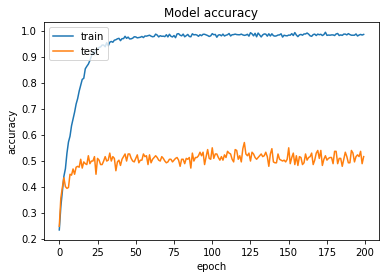

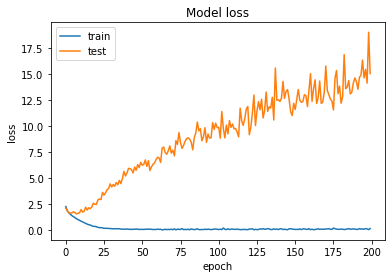

491/491 [==============================] - 0s 70us/step


In [72]:
mel_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('Mels',all_mel_ravd,mel_no_features_ravd,no_labels_ravd)

Train on 1666 samples, validate on 295 samples
Epoch 1/200
1666/1666 [==============================] - 1s 415us/step - loss: 2.6632 - accuracy: 0.1068 - val_loss: 2.4217 - val_accuracy: 0.1763
Epoch 2/200
1666/1666 [==============================] - 1s 319us/step - loss: 2.4268 - accuracy: 0.1357 - val_loss: 2.5405 - val_accuracy: 0.1797
Epoch 3/200
1666/1666 [==============================] - 1s 301us/step - loss: 2.3021 - accuracy: 0.1771 - val_loss: 2.3142 - val_accuracy: 0.2000
Epoch 4/200
1666/1666 [==============================] - 1s 327us/step - loss: 2.2311 - accuracy: 0.2161 - val_loss: 2.2974 - val_accuracy: 0.1627
Epoch 5/200
1666/1666 [==============================] - 1s 306us/step - loss: 2.1486 - accuracy: 0.2359 - val_loss: 2.1618 - val_accuracy: 0.2068
Epoch 6/200
1666/1666 [==============================] - 1s 317us/step - loss: 2.1170 - accuracy: 0.2539 - val_loss: 2.0980 - val_accuracy: 0.2475
Epoch 7/200
1666/1666 [==============================] - 1s 306us/step 

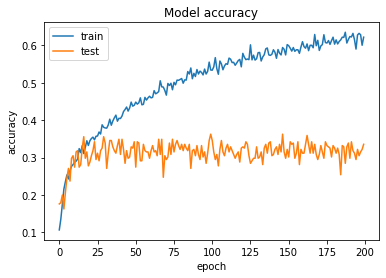

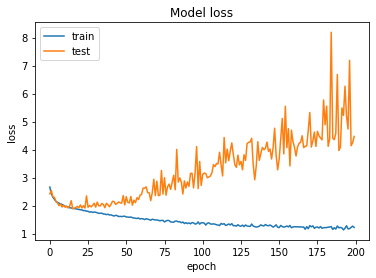

491/491 [==============================] - 0s 73us/step


In [73]:
chroma_model,predicts,realValues = split_data_fit_evaluate_the_dl_model('Chromas',all_chroma_ravd,chroma_no_features_ravd,no_labels_ravd)

Test the models

In [113]:
audio_file_ravdess = 'D:/Desktop/Ravdess/Actor_03/03-01-05-01-01-01-03.wav'
sampling_frequency_ravdess,bit_depth_ravdess,no_channels = verify_properties_of_audio(audio_file_ravdess)
sampling_frequency_ravdess,bit_depth_ravdess,no_channels

(48000, 2, 1)

In [114]:
import IPython
IPython.display.Audio(audio_file_ravdess, rate=sampling_frequency_ravdess)

In [115]:
def get_ravdess_label(audio_file):
    path, file = os.path.split(audio_file_ravdess)
    sintax_gender = path[-2:]
    if sintax_gender in ('02','04','06','08','10','12','14','16','18','20','22','24'):
        gender = 'Female '
    else:
        gender = 'Male '
        
    # get the emotion
    audio = os.path.splitext(file)[0]

    emotion = get_key_from_dict(emotions, audio[6:8])
    label = gender+emotion
    
    return label

In [116]:
for m in some_ml_models:
    mfcc_file,chroma_file,mel_file = extract_features(audio_file_ravdess)
    label_audio = get_ravdess_label(audio_file_ravdess)
    features = []
    features = np.hstack((mfcc_file,chroma_file,mel_file)).ravel()
    features = features.reshape(-1,180)
    y_pred = m.predict(features)
    y_pred = speech_encoder_ravd.inverse_transform(y_pred)
    print(y_pred)

['Male Disgust']
['Female Neutral']
['Male Angry']
['Male Angry']
['Female Sad']
